In [167]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from typing import Optional , Union , Tuple
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import accuracy_score
import plotly
from sklearn.model_selection import KFold

In [125]:
data = pd.read_csv('data/ssds.csv')


In [115]:
X_train ,X_ ,y_train ,y_ = train_test_split(data,target ,train_size = 0.7,stratify=target)
X_val,X_test ,y_val , y_test = train_test_split(X_,y_,test_size = 0.5,stratify=y_)

In [116]:
target = LabelEncoder().fit_transform(target)

In [117]:
X_val.columns

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')

In [118]:
X_train.to_csv('train_data.csv')

In [119]:
X_test.to_csv('test_data.csv')


In [120]:
X_val.to_csv('val_data.csv')

In [93]:
X_test = X_test.to_numpy()


In [126]:
Name0=data['Class'].unique()
Name=sorted(Name0)
print(Name)
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

['GALAXY', 'QSO', 'STAR']


In [129]:
dataY = data['Class'].map(normal_mapping)
dataX = data.drop(['Class','objid','specobjid','fiberid'],axis=1)
M=list(range(len(data)))
m=len(data)
np.random.seed(2021)
np.random.shuffle(M)
trainX=dataX.iloc[M[0:(m//4)*3]]
trainY=dataY.iloc[M[0:(m//4)*3]]
testX=dataX.iloc[M[(m//4)*3:]]
testY=dataY.iloc[M[(m//4)*3:]]

In [130]:
columns=dataX.columns.to_list()
print(columns)

['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol', 'field', 'redshift', 'plate', 'mjd']


In [141]:
def objective(trial,data=trainX,target=trainY):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param =   {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': trial.suggest_categorical('objective',['regression','rmse','multiclass','binary']),  
        'max_depth': -1,
        'learning_rate': 0.1,
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        "verbosity": -1,
    }
    model = lgb.LGBMClassifier(**param)      
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(test_x)
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [143]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)
print('Number of finished trials:', len(study.trials))


[I 2022-07-20 13:41:29,774] A new study created in memory with name: no-name-6583b19f-9152-4beb-8005-a4aedc7bbaf2
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.4922721292962597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4922721292962597
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.04597213935477414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04597213935477414
[LightGBM] [Warning] bagging_fraction is set=0.33037666471469085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33037666471469085
[LightGBM] [Warning] lambda_l1 is set=3.1770043129474964e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1770043129474964e-06


[I 2022-07-20 13:41:34,843] Trial 0 finished with value: 0.11372481406154654 and parameters: {'num_leaves': 254, 'objective': 'multiclass', 'lambda_l1': 3.1770043129474964e-06, 'lambda_l2': 0.04597213935477414, 'bagging_fraction': 0.33037666471469085, 'feature_fraction': 0.4922721292962597}. Best is trial 0 with value: 0.11372481406154654.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.4357449115213922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4357449115213922
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.3396127430780596e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3396127430780596e-08
[LightGBM] [Warning] bagging_fraction is set=0.10985589337201898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10985589337201898
[LightGBM] [Warning] lambda_l1 is set=1.4441470974506412e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4441470974506412e-07


[I 2022-07-20 13:41:36,490] Trial 1 finished with value: 0.1171893055416463 and parameters: {'num_leaves': 48, 'objective': 'multiclass', 'lambda_l1': 1.4441470974506412e-07, 'lambda_l2': 2.3396127430780596e-08, 'bagging_fraction': 0.10985589337201898, 'feature_fraction': 0.4357449115213922}. Best is trial 0 with value: 0.11372481406154654.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.7484072866099873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7484072866099873
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0008195607217749281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008195607217749281
[LightGBM] [Warning] bagging_fraction is set=0.7097840622129481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097840622129481
[LightGBM] [Warning] lambda_l1 is set=0.057088352404763607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.057088352404763607


[I 2022-07-20 13:41:40,618] Trial 2 finished with value: 0.10708252269472673 and parameters: {'num_leaves': 125, 'objective': 'binary', 'lambda_l1': 0.057088352404763607, 'lambda_l2': 0.0008195607217749281, 'bagging_fraction': 0.7097840622129481, 'feature_fraction': 0.7484072866099873}. Best is trial 2 with value: 0.10708252269472673.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.6493136551630208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6493136551630208
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00033414249832467173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033414249832467173
[LightGBM] [Warning] bagging_fraction is set=0.8211959343177649, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8211959343177649
[LightGBM] [Warning] lambda_l1 is set=0.06478173213408056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06478173213408056


[I 2022-07-20 13:41:42,925] Trial 3 finished with value: 0.10677078252031312 and parameters: {'num_leaves': 104, 'objective': 'binary', 'lambda_l1': 0.06478173213408056, 'lambda_l2': 0.00033414249832467173, 'bagging_fraction': 0.8211959343177649, 'feature_fraction': 0.6493136551630208}. Best is trial 3 with value: 0.10677078252031312.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.7060192606938172, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7060192606938172
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.0802969424918936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0802969424918936
[LightGBM] [Warning] bagging_fraction is set=0.11614062606617054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11614062606617054
[LightGBM] [Warning] lambda_l1 is set=4.2288190684290584e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2288190684290584e-08


[I 2022-07-20 13:41:44,500] Trial 4 finished with value: 0.11254628677422755 and parameters: {'num_leaves': 166, 'objective': 'binary', 'lambda_l1': 4.2288190684290584e-08, 'lambda_l2': 2.0802969424918936, 'bagging_fraction': 0.11614062606617054, 'feature_fraction': 0.7060192606938172}. Best is trial 3 with value: 0.10677078252031312.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9709930572060044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9709930572060044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.6588710373081863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6588710373081863
[LightGBM] [Warning] bagging_fraction is set=0.1061354718028662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1061354718028662
[LightGBM] [Warning] lambda_l1 is set=2.9875041033802274e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9875041033802274e-07


[I 2022-07-20 13:41:45,354] Trial 5 finished with value: 0.11460075625114056 and parameters: {'num_leaves': 22, 'objective': 'binary', 'lambda_l1': 2.9875041033802274e-07, 'lambda_l2': 2.6588710373081863, 'bagging_fraction': 0.1061354718028662, 'feature_fraction': 0.9709930572060044}. Best is trial 3 with value: 0.10677078252031312.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] feature_fraction is set=0.5484237541016936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484237541016936
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.772014442720661e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.772014442720661e-05
[LightGBM] [Warning] bagging_fraction is set=0.9912268391217889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9912268391217889
[LightGBM] [Warning] lambda_l1 is set=1.9070828165161843e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9070828165161843e-07


[I 2022-07-20 13:41:48,324] Trial 6 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 104, 'objective': 'regression', 'lambda_l1': 1.9070828165161843e-07, 'lambda_l2': 5.772014442720661e-05, 'bagging_fraction': 0.9912268391217889, 'feature_fraction': 0.5484237541016936}. Best is trial 6 with value: 0.10614455552060438.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.8116018470286724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8116018470286724
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.5390485308293675e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5390485308293675e-08
[LightGBM] [Warning] bagging_fraction is set=0.5758071468161063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5758071468161063
[LightGBM] [Warning] lambda_l1 is set=0.8989798058028273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8989798058028273


[I 2022-07-20 13:41:50,793] Trial 7 finished with value: 0.10739335795724675 and parameters: {'num_leaves': 139, 'objective': 'multiclass', 'lambda_l1': 0.8989798058028273, 'lambda_l2': 2.5390485308293675e-08, 'bagging_fraction': 0.5758071468161063, 'feature_fraction': 0.8116018470286724}. Best is trial 6 with value: 0.10614455552060438.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9139226727932052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9139226727932052
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.994673229612542e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.994673229612542e-08
[LightGBM] [Warning] bagging_fraction is set=0.8953996758921214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8953996758921214
[LightGBM] [Warning] lambda_l1 is set=2.7148388875654438e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7148388875654438e-05


[I 2022-07-20 13:41:55,854] Trial 8 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 239, 'objective': 'regression', 'lambda_l1': 2.7148388875654438e-05, 'lambda_l2': 4.994673229612542e-08, 'bagging_fraction': 0.8953996758921214, 'feature_fraction': 0.9139226727932052}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.5073262372224537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5073262372224537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.0907430055720737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0907430055720737
[LightGBM] [Warning] bagging_fraction is set=0.6362056418173033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6362056418173033
[LightGBM] [Warning] lambda_l1 is set=0.0007259815302532579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007259815302532579


[I 2022-07-20 13:41:57,393] Trial 9 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 66, 'objective': 'binary', 'lambda_l1': 0.0007259815302532579, 'lambda_l2': 2.0907430055720737, 'bagging_fraction': 0.6362056418173033, 'feature_fraction': 0.5073262372224537}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_wa

[LightGBM] [Warning] feature_fraction is set=0.9991187212324159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9991187212324159
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.008000751610113e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.008000751610113e-06
[LightGBM] [Warning] bagging_fraction is set=0.9316523798120431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9316523798120431
[LightGBM] [Warning] lambda_l1 is set=5.706339568991247e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.706339568991247e-05


[I 2022-07-20 13:42:00,924] Trial 10 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 244, 'objective': 'rmse', 'lambda_l1': 5.706339568991247e-05, 'lambda_l2': 2.008000751610113e-06, 'bagging_fraction': 0.9316523798120431, 'feature_fraction': 0.9991187212324159}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] feature_fraction is set=0.9928556876321541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9928556876321541
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.6726159282945706e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6726159282945706e-06
[LightGBM] [Warning] bagging_fraction is set=0.9865440574802464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9865440574802464
[LightGBM] [Warning] lambda_l1 is set=5.447383098916401e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.447383098916401e-05


[I 2022-07-20 13:42:04,471] Trial 11 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 255, 'objective': 'rmse', 'lambda_l1': 5.447383098916401e-05, 'lambda_l2': 1.6726159282945706e-06, 'bagging_fraction': 0.9865440574802464, 'feature_fraction': 0.9928556876321541}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.8846405344833511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8846405344833511
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.62208304987942e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.62208304987942e-07
[LightGBM] [Warning] bagging_fraction is set=0.8265919744274466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8265919744274466
[LightGBM] [Warning] lambda_l1 is set=0.0002594465303134786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002594465303134786


[I 2022-07-20 13:42:07,013] Trial 12 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 202, 'objective': 'regression', 'lambda_l1': 0.0002594465303134786, 'lambda_l2': 9.62208304987942e-07, 'bagging_fraction': 0.8265919744274466, 'feature_fraction': 0.8846405344833511}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.8896672144747497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8896672144747497
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0444684584074411e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0444684584074411e-06
[LightGBM] [Warning] bagging_fraction is set=0.4112424825901916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4112424825901916
[LightGBM] [Warning] lambda_l1 is set=1.8446209440268886e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8446209440268886e-05


[I 2022-07-20 13:42:09,732] Trial 13 finished with value: 0.10677078252031312 and parameters: {'num_leaves': 208, 'objective': 'rmse', 'lambda_l1': 1.8446209440268886e-05, 'lambda_l2': 1.0444684584074411e-06, 'bagging_fraction': 0.4112424825901916, 'feature_fraction': 0.8896672144747497}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.901899519857398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901899519857398
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.6925101404198825e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.6925101404198825e-06
[LightGBM] [Warning] bagging_fraction is set=0.8502732433964807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8502732433964807
[LightGBM] [Warning] lambda_l1 is set=0.003100374721383924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003100374721383924


[I 2022-07-20 13:42:12,917] Trial 14 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 205, 'objective': 'rmse', 'lambda_l1': 0.003100374721383924, 'lambda_l2': 6.6925101404198825e-06, 'bagging_fraction': 0.8502732433964807, 'feature_fraction': 0.901899519857398}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_w

[LightGBM] [Warning] feature_fraction is set=0.8136464240995421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8136464240995421
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.705438742655733e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.705438742655733e-08
[LightGBM] [Warning] bagging_fraction is set=0.7267874551988887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267874551988887
[LightGBM] [Warning] lambda_l1 is set=2.17884216953385e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.17884216953385e-06


[I 2022-07-20 13:42:16,135] Trial 15 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 230, 'objective': 'regression', 'lambda_l1': 2.17884216953385e-06, 'lambda_l2': 7.705438742655733e-08, 'bagging_fraction': 0.7267874551988887, 'feature_fraction': 0.8136464240995421}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9495248583548889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9495248583548889
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.880729242889146e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.880729242889146e-05
[LightGBM] [Warning] bagging_fraction is set=0.9220877316410009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9220877316410009
[LightGBM] [Warning] lambda_l1 is set=0.011039526106464222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011039526106464222


[I 2022-07-20 13:42:18,591] Trial 16 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 171, 'objective': 'regression', 'lambda_l1': 0.011039526106464222, 'lambda_l2': 2.880729242889146e-05, 'bagging_fraction': 0.9220877316410009, 'feature_fraction': 0.9495248583548889}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.8122634832213421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8122634832213421
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.3674251380025354e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3674251380025354e-07
[LightGBM] [Warning] bagging_fraction is set=0.5004428735952706, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004428735952706
[LightGBM] [Warning] lambda_l1 is set=3.421384729619853e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.421384729619853e-05


[I 2022-07-20 13:42:21,447] Trial 17 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 176, 'objective': 'rmse', 'lambda_l1': 3.421384729619853e-05, 'lambda_l2': 2.3674251380025354e-07, 'bagging_fraction': 0.5004428735952706, 'feature_fraction': 0.8122634832213421}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9980082786474902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9980082786474902
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.009420039841875269, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009420039841875269
[LightGBM] [Warning] bagging_fraction is set=0.738656664887447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.738656664887447
[LightGBM] [Warning] lambda_l1 is set=8.068638838474332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.068638838474332


[I 2022-07-20 13:42:22,572] Trial 18 finished with value: 0.1089342309224546 and parameters: {'num_leaves': 228, 'objective': 'rmse', 'lambda_l1': 8.068638838474332, 'lambda_l2': 0.009420039841875269, 'bagging_fraction': 0.738656664887447, 'feature_fraction': 0.9980082786474902}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.6118759829805385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6118759829805385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.779744611974134e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.779744611974134e-07
[LightGBM] [Warning] bagging_fraction is set=0.8860413136406505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8860413136406505
[LightGBM] [Warning] lambda_l1 is set=2.681967028469108e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.681967028469108e-06


[I 2022-07-20 13:42:25,943] Trial 19 finished with value: 0.10770329614269007 and parameters: {'num_leaves': 226, 'objective': 'regression', 'lambda_l1': 2.681967028469108e-06, 'lambda_l2': 2.779744611974134e-07, 'bagging_fraction': 0.8860413136406505, 'feature_fraction': 0.6118759829805385}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9207359059420219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9207359059420219
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3645732299134493e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3645732299134493e-05
[LightGBM] [Warning] bagging_fraction is set=0.28432186773576074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28432186773576074
[LightGBM] [Warning] lambda_l1 is set=0.00021935201011015086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021935201011015086


[I 2022-07-20 13:42:28,391] Trial 20 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 187, 'objective': 'rmse', 'lambda_l1': 0.00021935201011015086, 'lambda_l2': 1.3645732299134493e-05, 'bagging_fraction': 0.28432186773576074, 'feature_fraction': 0.9207359059420219}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9981499634462969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9981499634462969
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.5223639237629966e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5223639237629966e-06
[LightGBM] [Warning] bagging_fraction is set=0.9785477857124224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785477857124224
[LightGBM] [Warning] lambda_l1 is set=3.078661743915703e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.078661743915703e-05


[I 2022-07-20 13:42:31,896] Trial 21 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 253, 'objective': 'rmse', 'lambda_l1': 3.078661743915703e-05, 'lambda_l2': 2.5223639237629966e-06, 'bagging_fraction': 0.9785477857124224, 'feature_fraction': 0.9981499634462969}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.8529609893688314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8529609893688314
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3388260894239972e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3388260894239972e-08
[LightGBM] [Warning] bagging_fraction is set=0.9323110773291424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9323110773291424
[LightGBM] [Warning] lambda_l1 is set=9.67316018092614e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.67316018092614e-06


[I 2022-07-20 13:42:36,289] Trial 22 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 242, 'objective': 'rmse', 'lambda_l1': 9.67316018092614e-06, 'lambda_l2': 1.3388260894239972e-08, 'bagging_fraction': 0.9323110773291424, 'feature_fraction': 0.8529609893688314}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] feature_fraction is set=0.9398088699740568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9398088699740568
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.7444774765097992e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7444774765097992e-06
[LightGBM] [Warning] bagging_fraction is set=0.7715240009136175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7715240009136175
[LightGBM] [Warning] lambda_l1 is set=0.0011905468092010816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011905468092010816


[I 2022-07-20 13:42:39,347] Trial 23 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 220, 'objective': 'rmse', 'lambda_l1': 0.0011905468092010816, 'lambda_l2': 2.7444774765097992e-06, 'bagging_fraction': 0.7715240009136175, 'feature_fraction': 0.9398088699740568}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9323236245546549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9323236245546549
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.464161332990465e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.464161332990465e-05
[LightGBM] [Warning] bagging_fraction is set=0.7803618690748191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7803618690748191
[LightGBM] [Warning] lambda_l1 is set=0.0012913537008339916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012913537008339916


[I 2022-07-20 13:42:42,333] Trial 24 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 217, 'objective': 'regression', 'lambda_l1': 0.0012913537008339916, 'lambda_l2': 8.464161332990465e-05, 'bagging_fraction': 0.7803618690748191, 'feature_fraction': 0.9323236245546549}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.8420885411882968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8420885411882968
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.17961819625347e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.17961819625347e-07
[LightGBM] [Warning] bagging_fraction is set=0.9979221471589121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979221471589121
[LightGBM] [Warning] lambda_l1 is set=0.00011949071824373113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011949071824373113


[I 2022-07-20 13:42:46,413] Trial 25 finished with value: 0.10708252269472673 and parameters: {'num_leaves': 255, 'objective': 'rmse', 'lambda_l1': 0.00011949071824373113, 'lambda_l2': 1.17961819625347e-07, 'bagging_fraction': 0.9979221471589121, 'feature_fraction': 0.8420885411882968}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] feature_fraction is set=0.7580756472124295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7580756472124295
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0017651805999883922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017651805999883922
[LightGBM] [Warning] bagging_fraction is set=0.659878482621981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.659878482621981
[LightGBM] [Warning] lambda_l1 is set=0.003405167270031075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003405167270031075


[I 2022-07-20 13:42:48,858] Trial 26 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 153, 'objective': 'rmse', 'lambda_l1': 0.003405167270031075, 'lambda_l2': 0.0017651805999883922, 'bagging_fraction': 0.659878482621981, 'feature_fraction': 0.7580756472124295}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_w

[LightGBM] [Warning] feature_fraction is set=0.9496122766749966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9496122766749966
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.485183704343639e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.485183704343639e-06
[LightGBM] [Warning] bagging_fraction is set=0.8836591542016385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836591542016385
[LightGBM] [Warning] lambda_l1 is set=0.007579351400575014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007579351400575014


[I 2022-07-20 13:42:51,643] Trial 27 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 194, 'objective': 'regression', 'lambda_l1': 0.007579351400575014, 'lambda_l2': 7.485183704343639e-06, 'bagging_fraction': 0.8836591542016385, 'feature_fraction': 0.9496122766749966}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.8690389772296022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8690389772296022
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.381517607358552e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.381517607358552e-07
[LightGBM] [Warning] bagging_fraction is set=0.7825306551364254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7825306551364254
[LightGBM] [Warning] lambda_l1 is set=1.1454788605742876e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1454788605742876e-08


[I 2022-07-20 13:42:54,971] Trial 28 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 220, 'objective': 'multiclass', 'lambda_l1': 1.1454788605742876e-08, 'lambda_l2': 4.381517607358552e-07, 'bagging_fraction': 0.7825306551364254, 'feature_fraction': 0.8690389772296022}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9333929350990442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9333929350990442
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.12416864764521927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12416864764521927
[LightGBM] [Warning] bagging_fraction is set=0.544190029137768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.544190029137768
[LightGBM] [Warning] lambda_l1 is set=3.5089454369120483e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5089454369120483e-06


[I 2022-07-20 13:42:57,383] Trial 29 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 236, 'objective': 'multiclass', 'lambda_l1': 3.5089454369120483e-06, 'lambda_l2': 0.12416864764521927, 'bagging_fraction': 0.544190029137768, 'feature_fraction': 0.9333929350990442}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.7338777256769902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7338777256769902
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.8587745963160886e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8587745963160886e-08
[LightGBM] [Warning] bagging_fraction is set=0.6581141680952387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6581141680952387
[LightGBM] [Warning] lambda_l1 is set=0.07132436856975043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07132436856975043


[I 2022-07-20 13:42:59,854] Trial 30 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 188, 'objective': 'rmse', 'lambda_l1': 0.07132436856975043, 'lambda_l2': 4.8587745963160886e-08, 'bagging_fraction': 0.6581141680952387, 'feature_fraction': 0.7338777256769902}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] feature_fraction is set=0.9860252164351434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9860252164351434
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.981225777135469e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.981225777135469e-06
[LightGBM] [Warning] bagging_fraction is set=0.9325933177403205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9325933177403205
[LightGBM] [Warning] lambda_l1 is set=9.368262626066603e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.368262626066603e-06


[I 2022-07-20 13:43:03,306] Trial 31 finished with value: 0.10677078252031312 and parameters: {'num_leaves': 241, 'objective': 'rmse', 'lambda_l1': 9.368262626066603e-06, 'lambda_l2': 1.981225777135469e-06, 'bagging_fraction': 0.9325933177403205, 'feature_fraction': 0.9860252164351434}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] feature_fraction is set=0.9656254301278523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9656254301278523
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.5365780461284847e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5365780461284847e-06
[LightGBM] [Warning] bagging_fraction is set=0.9313966970436555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9313966970436555
[LightGBM] [Warning] lambda_l1 is set=7.894091509781729e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.894091509781729e-07


[I 2022-07-20 13:43:06,630] Trial 32 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 252, 'objective': 'rmse', 'lambda_l1': 7.894091509781729e-07, 'lambda_l2': 3.5365780461284847e-06, 'bagging_fraction': 0.9313966970436555, 'feature_fraction': 0.9656254301278523}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9981533355808938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9981533355808938
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00012688264290909769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012688264290909769
[LightGBM] [Warning] bagging_fraction is set=0.875143905779277, subsample=1.0 will be ignored. Current value: bagging_fraction=0.875143905779277
[LightGBM] [Warning] lambda_l1 is set=8.230156966745322e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.230156966745322e-05


[I 2022-07-20 13:43:09,771] Trial 33 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 214, 'objective': 'rmse', 'lambda_l1': 8.230156966745322e-05, 'lambda_l2': 0.00012688264290909769, 'bagging_fraction': 0.875143905779277, 'feature_fraction': 0.9981533355808938}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] feature_fraction is set=0.9258376913781374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258376913781374
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00019100910226145005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019100910226145005
[LightGBM] [Warning] bagging_fraction is set=0.7745820177446104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7745820177446104
[LightGBM] [Warning] lambda_l1 is set=9.128143927914509e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.128143927914509e-05


[I 2022-07-20 13:43:12,933] Trial 34 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 213, 'objective': 'rmse', 'lambda_l1': 9.128143927914509e-05, 'lambda_l2': 0.00019100910226145005, 'bagging_fraction': 0.7745820177446104, 'feature_fraction': 0.9258376913781374}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.41423532129205803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41423532129205803
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.8804276119122834e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8804276119122834e-05
[LightGBM] [Warning] bagging_fraction is set=0.8640406614287669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8640406614287669
[LightGBM] [Warning] lambda_l1 is set=2.439714735582343e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.439714735582343e-05


[I 2022-07-20 13:43:16,452] Trial 35 finished with value: 0.11075498483890767 and parameters: {'num_leaves': 240, 'objective': 'multiclass', 'lambda_l1': 2.439714735582343e-05, 'lambda_l2': 1.8804276119122834e-05, 'bagging_fraction': 0.8640406614287669, 'feature_fraction': 0.41423532129205803}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.9035536530368515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9035536530368515
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0007328572960378855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007328572960378855
[LightGBM] [Warning] bagging_fraction is set=0.8079271962992814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8079271962992814
[LightGBM] [Warning] lambda_l1 is set=0.000798336687871647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000798336687871647


[I 2022-07-20 13:43:19,055] Trial 36 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 149, 'objective': 'rmse', 'lambda_l1': 0.000798336687871647, 'lambda_l2': 0.0007328572960378855, 'bagging_fraction': 0.8079271962992814, 'feature_fraction': 0.9035536530368515}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] feature_fraction is set=0.9570760278111088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570760278111088
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.004217048627864445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004217048627864445
[LightGBM] [Warning] bagging_fraction is set=0.8957717844943152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8957717844943152
[LightGBM] [Warning] lambda_l1 is set=0.0003936168641617055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003936168641617055


[I 2022-07-20 13:43:20,742] Trial 37 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 75, 'objective': 'binary', 'lambda_l1': 0.0003936168641617055, 'lambda_l2': 0.004217048627864445, 'bagging_fraction': 0.8957717844943152, 'feature_fraction': 0.9570760278111088}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] feature_fraction is set=0.6414663790527237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6414663790527237
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.519308209002083e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.519308209002083e-05
[LightGBM] [Warning] bagging_fraction is set=0.8382980266172945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8382980266172945
[LightGBM] [Warning] lambda_l1 is set=0.17356187633672535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17356187633672535


[I 2022-07-20 13:43:21,285] Trial 38 finished with value: 0.1116542281629615 and parameters: {'num_leaves': 4, 'objective': 'regression', 'lambda_l1': 0.17356187633672535, 'lambda_l2': 8.519308209002083e-05, 'bagging_fraction': 0.8382980266172945, 'feature_fraction': 0.6414663790527237}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.8648397944363337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8648397944363337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00029458247924214704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029458247924214704
[LightGBM] [Warning] bagging_fraction is set=0.6901489026179977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6901489026179977
[LightGBM] [Warning] lambda_l1 is set=5.852169883499851e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.852169883499851e-07


[I 2022-07-20 13:43:23,991] Trial 39 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 198, 'objective': 'binary', 'lambda_l1': 5.852169883499851e-07, 'lambda_l2': 0.00029458247924214704, 'bagging_fraction': 0.6901489026179977, 'feature_fraction': 0.8648397944363337}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9934153191837481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9934153191837481
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.053256622353893085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.053256622353893085
[LightGBM] [Warning] bagging_fraction is set=0.9744097841870334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9744097841870334
[LightGBM] [Warning] lambda_l1 is set=7.141736458200614e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.141736458200614e-06


[I 2022-07-20 13:43:25,985] Trial 40 finished with value: 0.10295630140987 and parameters: {'num_leaves': 120, 'objective': 'rmse', 'lambda_l1': 7.141736458200614e-06, 'lambda_l2': 0.053256622353893085, 'bagging_fraction': 0.9744097841870334, 'feature_fraction': 0.9934153191837481}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_war

[LightGBM] [Warning] feature_fraction is set=0.9632391166430154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9632391166430154
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.21706887477737316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21706887477737316
[LightGBM] [Warning] bagging_fraction is set=0.9243896634038498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243896634038498
[LightGBM] [Warning] lambda_l1 is set=1.0880006437081698e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0880006437081698e-05


[I 2022-07-20 13:43:27,833] Trial 41 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 99, 'objective': 'rmse', 'lambda_l1': 1.0880006437081698e-05, 'lambda_l2': 0.21706887477737316, 'bagging_fraction': 0.9243896634038498, 'feature_fraction': 0.9632391166430154}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_w

[LightGBM] [Warning] feature_fraction is set=0.9994554306446919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994554306446919
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.016073384814197685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016073384814197685
[LightGBM] [Warning] bagging_fraction is set=0.9561430223959331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9561430223959331
[LightGBM] [Warning] lambda_l1 is set=9.873629983619206e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.873629983619206e-05


[I 2022-07-20 13:43:29,678] Trial 42 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 95, 'objective': 'rmse', 'lambda_l1': 9.873629983619206e-05, 'lambda_l2': 0.016073384814197685, 'bagging_fraction': 0.9561430223959331, 'feature_fraction': 0.9994554306446919}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_wa

[LightGBM] [Warning] feature_fraction is set=0.9822353211454965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9822353211454965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.6182537650167815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6182537650167815
[LightGBM] [Warning] bagging_fraction is set=0.9722809738098113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9722809738098113
[LightGBM] [Warning] lambda_l1 is set=5.1163202689996775e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1163202689996775e-06


[I 2022-07-20 13:43:31,607] Trial 43 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 112, 'objective': 'rmse', 'lambda_l1': 5.1163202689996775e-06, 'lambda_l2': 0.6182537650167815, 'bagging_fraction': 0.9722809738098113, 'feature_fraction': 0.9822353211454965}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_w

[LightGBM] [Warning] feature_fraction is set=0.9981694628720462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9981694628720462
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0155434824078153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0155434824078153e-08
[LightGBM] [Warning] bagging_fraction is set=0.9954358716950185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9954358716950185
[LightGBM] [Warning] lambda_l1 is set=1.1635900604088388e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1635900604088388e-06


[I 2022-07-20 13:43:34,869] Trial 44 finished with value: 0.10295630140987 and parameters: {'num_leaves': 255, 'objective': 'rmse', 'lambda_l1': 1.1635900604088388e-06, 'lambda_l2': 1.0155434824078153e-08, 'bagging_fraction': 0.9954358716950185, 'feature_fraction': 0.9981694628720462}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] feature_fraction is set=0.9099445632263454, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9099445632263454
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1982095005381273e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1982095005381273e-08
[LightGBM] [Warning] bagging_fraction is set=0.8893634792569635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8893634792569635
[LightGBM] [Warning] lambda_l1 is set=4.829837862446621e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.829837862446621e-08


[I 2022-07-20 13:43:36,707] Trial 45 finished with value: 0.10677078252031312 and parameters: {'num_leaves': 79, 'objective': 'regression', 'lambda_l1': 4.829837862446621e-08, 'lambda_l2': 1.1982095005381273e-08, 'bagging_fraction': 0.8893634792569635, 'feature_fraction': 0.9099445632263454}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9689826856947826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9689826856947826
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.4134610882150324e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4134610882150324e-08
[LightGBM] [Warning] bagging_fraction is set=0.9983718496174904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9983718496174904
[LightGBM] [Warning] lambda_l1 is set=7.584013324368855e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.584013324368855e-07


[I 2022-07-20 13:43:39,241] Trial 46 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 132, 'objective': 'rmse', 'lambda_l1': 7.584013324368855e-07, 'lambda_l2': 4.4134610882150324e-08, 'bagging_fraction': 0.9983718496174904, 'feature_fraction': 0.9689826856947826}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.5765952382355737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5765952382355737
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.4516506631780024e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4516506631780024e-07
[LightGBM] [Warning] bagging_fraction is set=0.1965452481665751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1965452481665751
[LightGBM] [Warning] lambda_l1 is set=9.015670325972258e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.015670325972258e-08


[I 2022-07-20 13:43:41,913] Trial 47 finished with value: 0.11343133018115703 and parameters: {'num_leaves': 158, 'objective': 'binary', 'lambda_l1': 9.015670325972258e-08, 'lambda_l2': 1.4516506631780024e-07, 'bagging_fraction': 0.1965452481665751, 'feature_fraction': 0.5765952382355737}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9704400874181763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9704400874181763
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.468783472303968e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.468783472303968e-07
[LightGBM] [Warning] bagging_fraction is set=0.840958856380632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.840958856380632
[LightGBM] [Warning] lambda_l1 is set=1.914740322462214e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.914740322462214e-06


[I 2022-07-20 13:43:45,566] Trial 48 finished with value: 0.10295630140987 and parameters: {'num_leaves': 244, 'objective': 'multiclass', 'lambda_l1': 1.914740322462214e-06, 'lambda_l2': 5.468783472303968e-07, 'bagging_fraction': 0.840958856380632, 'feature_fraction': 0.9704400874181763}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.4871548142755328, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4871548142755328
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.5026473177392465e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5026473177392465e-07
[LightGBM] [Warning] bagging_fraction is set=0.8393356609253447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8393356609253447
[LightGBM] [Warning] lambda_l1 is set=1.2085672313155668e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2085672313155668e-06


[I 2022-07-20 13:43:49,299] Trial 49 finished with value: 0.11224972160321824 and parameters: {'num_leaves': 245, 'objective': 'multiclass', 'lambda_l1': 1.2085672313155668e-06, 'lambda_l2': 4.5026473177392465e-07, 'bagging_fraction': 0.8393356609253447, 'feature_fraction': 0.4871548142755328}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.7837055553591183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7837055553591183
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.758012816766394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.758012816766394
[LightGBM] [Warning] bagging_fraction is set=0.5979800317872869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5979800317872869
[LightGBM] [Warning] lambda_l1 is set=2.2863429629329953e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2863429629329953e-07


[I 2022-07-20 13:43:51,475] Trial 50 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 179, 'objective': 'multiclass', 'lambda_l1': 2.2863429629329953e-07, 'lambda_l2': 5.758012816766394, 'bagging_fraction': 0.5979800317872869, 'feature_fraction': 0.7837055553591183}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9735903635149681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9735903635149681
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.5923978595490202e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5923978595490202e-08
[LightGBM] [Warning] bagging_fraction is set=0.9577051967270708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9577051967270708
[LightGBM] [Warning] lambda_l1 is set=1.7805354256879136e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7805354256879136e-06


[I 2022-07-20 13:43:54,569] Trial 51 finished with value: 0.10295630140987 and parameters: {'num_leaves': 231, 'objective': 'multiclass', 'lambda_l1': 1.7805354256879136e-06, 'lambda_l2': 2.5923978595490202e-08, 'bagging_fraction': 0.9577051967270708, 'feature_fraction': 0.9735903635149681}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9715809918636301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9715809918636301
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.309178014430959e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.309178014430959e-08
[LightGBM] [Warning] bagging_fraction is set=0.9503904076217677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9503904076217677
[LightGBM] [Warning] lambda_l1 is set=5.1264837563829e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1264837563829e-05


[I 2022-07-20 13:43:56,733] Trial 52 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 121, 'objective': 'multiclass', 'lambda_l1': 5.1264837563829e-05, 'lambda_l2': 3.309178014430959e-08, 'bagging_fraction': 0.9503904076217677, 'feature_fraction': 0.9715809918636301}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.8832125757300947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8832125757300947
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.051365163968365e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.051365163968365e-07
[LightGBM] [Warning] bagging_fraction is set=0.8999399803120529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8999399803120529
[LightGBM] [Warning] lambda_l1 is set=3.8964910104676397e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8964910104676397e-07


[I 2022-07-20 13:44:00,057] Trial 53 finished with value: 0.10770329614269007 and parameters: {'num_leaves': 209, 'objective': 'rmse', 'lambda_l1': 3.8964910104676397e-07, 'lambda_l2': 7.051365163968365e-07, 'bagging_fraction': 0.8999399803120529, 'feature_fraction': 0.8832125757300947}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9478450292769562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9478450292769562
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.144304736909595e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.144304736909595e-07
[LightGBM] [Warning] bagging_fraction is set=0.8543181095867199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8543181095867199
[LightGBM] [Warning] lambda_l1 is set=6.643094516158566e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.643094516158566e-06


[I 2022-07-20 13:44:03,069] Trial 54 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 232, 'objective': 'multiclass', 'lambda_l1': 6.643094516158566e-06, 'lambda_l2': 2.144304736909595e-07, 'bagging_fraction': 0.8543181095867199, 'feature_fraction': 0.9478450292769562}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.8319163744714907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8319163744714907
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.984623800133377e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.984623800133377e-08
[LightGBM] [Warning] bagging_fraction is set=0.44600726528851314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44600726528851314
[LightGBM] [Warning] lambda_l1 is set=1.6405473859971308e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6405473859971308e-05


[I 2022-07-20 13:44:05,929] Trial 55 finished with value: 0.10677078252031312 and parameters: {'num_leaves': 231, 'objective': 'multiclass', 'lambda_l1': 1.6405473859971308e-05, 'lambda_l2': 8.984623800133377e-08, 'bagging_fraction': 0.44600726528851314, 'feature_fraction': 0.8319163744714907}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.9108220494704424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9108220494704424
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.023362108729878e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.023362108729878e-07
[LightGBM] [Warning] bagging_fraction is set=0.7387601098766339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7387601098766339
[LightGBM] [Warning] lambda_l1 is set=0.00018100881523838448, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018100881523838448


[I 2022-07-20 13:44:08,758] Trial 56 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 226, 'objective': 'multiclass', 'lambda_l1': 0.00018100881523838448, 'lambda_l2': 2.023362108729878e-07, 'bagging_fraction': 0.7387601098766339, 'feature_fraction': 0.9108220494704424}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.6902644696498625, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6902644696498625
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.922990496988723e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.922990496988723e-07
[LightGBM] [Warning] bagging_fraction is set=0.8205330677920373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205330677920373
[LightGBM] [Warning] lambda_l1 is set=5.389048874916467e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.389048874916467e-05


[I 2022-07-20 13:44:12,338] Trial 57 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 236, 'objective': 'multiclass', 'lambda_l1': 5.389048874916467e-05, 'lambda_l2': 8.922990496988723e-07, 'bagging_fraction': 0.8205330677920373, 'feature_fraction': 0.6902644696498625}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9450032538227149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9450032538227149
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.3078384609279587e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3078384609279587e-08
[LightGBM] [Warning] bagging_fraction is set=0.8564761704145338, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8564761704145338
[LightGBM] [Warning] lambda_l1 is set=2.272404934431145e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.272404934431145e-06


[I 2022-07-20 13:44:15,804] Trial 58 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 222, 'objective': 'multiclass', 'lambda_l1': 2.272404934431145e-06, 'lambda_l2': 2.3078384609279587e-08, 'bagging_fraction': 0.8564761704145338, 'feature_fraction': 0.9450032538227149}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.8921263357850456, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8921263357850456
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.330707947390955e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.330707947390955e-06
[LightGBM] [Warning] bagging_fraction is set=0.8062421274925389, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8062421274925389
[LightGBM] [Warning] lambda_l1 is set=0.000404224515567522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000404224515567522


[I 2022-07-20 13:44:18,630] Trial 59 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 205, 'objective': 'multiclass', 'lambda_l1': 0.000404224515567522, 'lambda_l2': 6.330707947390955e-06, 'bagging_fraction': 0.8062421274925389, 'feature_fraction': 0.8921263357850456}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.926600082455415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.926600082455415
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.6044014843297426e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6044014843297426e-07
[LightGBM] [Warning] bagging_fraction is set=0.8657325736359052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8657325736359052
[LightGBM] [Warning] lambda_l1 is set=4.632562933889551e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.632562933889551e-06


[I 2022-07-20 13:44:21,839] Trial 60 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 245, 'objective': 'multiclass', 'lambda_l1': 4.632562933889551e-06, 'lambda_l2': 2.6044014843297426e-07, 'bagging_fraction': 0.8657325736359052, 'feature_fraction': 0.926600082455415}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9863616971746387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9863616971746387
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.764355869185871e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.764355869185871e-08
[LightGBM] [Warning] bagging_fraction is set=0.9577043942412394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9577043942412394
[LightGBM] [Warning] lambda_l1 is set=1.0111393792684264e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0111393792684264e-05


[I 2022-07-20 13:44:25,100] Trial 61 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 255, 'objective': 'regression', 'lambda_l1': 1.0111393792684264e-05, 'lambda_l2': 1.764355869185871e-08, 'bagging_fraction': 0.9577043942412394, 'feature_fraction': 0.9863616971746387}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9980556324181972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9980556324181972
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.2292034746791436e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2292034746791436e-08
[LightGBM] [Warning] bagging_fraction is set=0.916851817555533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.916851817555533
[LightGBM] [Warning] lambda_l1 is set=5.2308706771531855e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2308706771531855e-06


[I 2022-07-20 13:44:28,230] Trial 62 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 228, 'objective': 'rmse', 'lambda_l1': 5.2308706771531855e-06, 'lambda_l2': 5.2292034746791436e-08, 'bagging_fraction': 0.916851817555533, 'feature_fraction': 0.9980556324181972}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.955753411321886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.955753411321886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.433691675816431e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.433691675816431e-05
[LightGBM] [Warning] bagging_fraction is set=0.8758476797181138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758476797181138
[LightGBM] [Warning] lambda_l1 is set=2.2272169645997577e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2272169645997577e-05


[I 2022-07-20 13:44:29,512] Trial 63 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 43, 'objective': 'regression', 'lambda_l1': 2.2272169645997577e-05, 'lambda_l2': 4.433691675816431e-05, 'bagging_fraction': 0.8758476797181138, 'feature_fraction': 0.955753411321886}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9419530123252058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9419530123252058
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.91241734951773e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.91241734951773e-08
[LightGBM] [Warning] bagging_fraction is set=0.9748388344346322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9748388344346322
[LightGBM] [Warning] lambda_l1 is set=1.346718028160167e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.346718028160167e-06


[I 2022-07-20 13:44:32,809] Trial 64 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 214, 'objective': 'rmse', 'lambda_l1': 1.346718028160167e-06, 'lambda_l2': 8.91241734951773e-08, 'bagging_fraction': 0.9748388344346322, 'feature_fraction': 0.9419530123252058}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_

[LightGBM] [Warning] feature_fraction is set=0.9748017657716994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9748017657716994
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.02704350133327537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02704350133327537
[LightGBM] [Warning] bagging_fraction is set=0.9100956074372364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9100956074372364
[LightGBM] [Warning] lambda_l1 is set=3.607705504641623e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.607705504641623e-05


[I 2022-07-20 13:44:35,911] Trial 65 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 246, 'objective': 'multiclass', 'lambda_l1': 3.607705504641623e-05, 'lambda_l2': 0.02704350133327537, 'bagging_fraction': 0.9100956074372364, 'feature_fraction': 0.9748017657716994}. Best is trial 8 with value: 0.1019803902718557.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9193351516870789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9193351516870789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1309379780150784e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1309379780150784e-06
[LightGBM] [Warning] bagging_fraction is set=0.7408845159010187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7408845159010187
[LightGBM] [Warning] lambda_l1 is set=6.17603751609438e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.17603751609438e-06


[I 2022-07-20 13:44:38,501] Trial 66 finished with value: 0.10132456102380442 and parameters: {'num_leaves': 141, 'objective': 'rmse', 'lambda_l1': 6.17603751609438e-06, 'lambda_l2': 1.1309379780150784e-06, 'bagging_fraction': 0.7408845159010187, 'feature_fraction': 0.9193351516870789}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.8776948500681914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8776948500681914
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3069888244141293e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3069888244141293e-06
[LightGBM] [Warning] bagging_fraction is set=0.7979133388595824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7979133388595824
[LightGBM] [Warning] lambda_l1 is set=8.998563529765847e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.998563529765847e-05


[I 2022-07-20 13:44:41,657] Trial 67 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 250, 'objective': 'rmse', 'lambda_l1': 8.998563529765847e-05, 'lambda_l2': 1.3069888244141293e-06, 'bagging_fraction': 0.7979133388595824, 'feature_fraction': 0.8776948500681914}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9170487384582491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9170487384582491
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.009002234919289e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.009002234919289e-06
[LightGBM] [Warning] bagging_fraction is set=0.7145048417567628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7145048417567628
[LightGBM] [Warning] lambda_l1 is set=5.90105984143343e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.90105984143343e-06


[I 2022-07-20 13:44:44,110] Trial 68 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 141, 'objective': 'rmse', 'lambda_l1': 5.90105984143343e-06, 'lambda_l2': 5.009002234919289e-06, 'bagging_fraction': 0.7145048417567628, 'feature_fraction': 0.9170487384582491}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9472312832107483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9472312832107483
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.767981340546681e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.767981340546681e-07
[LightGBM] [Warning] bagging_fraction is set=0.757032660826033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.757032660826033
[LightGBM] [Warning] lambda_l1 is set=1.4118541170699376e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4118541170699376e-05


[I 2022-07-20 13:44:46,275] Trial 69 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 118, 'objective': 'regression', 'lambda_l1': 1.4118541170699376e-05, 'lambda_l2': 4.767981340546681e-07, 'bagging_fraction': 0.757032660826033, 'feature_fraction': 0.9472312832107483}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.8544309868197281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8544309868197281
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.197108198785944e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.197108198785944e-05
[LightGBM] [Warning] bagging_fraction is set=0.8367494339590383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8367494339590383
[LightGBM] [Warning] lambda_l1 is set=2.896559361562347e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.896559361562347e-06


[I 2022-07-20 13:44:49,410] Trial 70 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 233, 'objective': 'binary', 'lambda_l1': 2.896559361562347e-06, 'lambda_l2': 1.197108198785944e-05, 'bagging_fraction': 0.8367494339590383, 'feature_fraction': 0.8544309868197281}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9828416364771387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9828416364771387
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.004663226151946821, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004663226151946821
[LightGBM] [Warning] bagging_fraction is set=0.9367112287157251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9367112287157251
[LightGBM] [Warning] lambda_l1 is set=1.1255903108328084e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1255903108328084e-06


[I 2022-07-20 13:44:51,588] Trial 71 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 131, 'objective': 'rmse', 'lambda_l1': 1.1255903108328084e-06, 'lambda_l2': 0.004663226151946821, 'bagging_fraction': 0.9367112287157251, 'feature_fraction': 0.9828416364771387}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9612690577998039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9612690577998039
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9873653482372969e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9873653482372969e-07
[LightGBM] [Warning] bagging_fraction is set=0.8682720889338871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8682720889338871
[LightGBM] [Warning] lambda_l1 is set=7.84236219422282e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.84236219422282e-06


[I 2022-07-20 13:44:54,738] Trial 72 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 238, 'objective': 'multiclass', 'lambda_l1': 7.84236219422282e-06, 'lambda_l2': 1.9873653482372969e-07, 'bagging_fraction': 0.8682720889338871, 'feature_fraction': 0.9612690577998039}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.9275071801581664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275071801581664
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1444736031498316e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1444736031498316e-08
[LightGBM] [Warning] bagging_fraction is set=0.994577915509451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.994577915509451
[LightGBM] [Warning] lambda_l1 is set=2.5239173998122554e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5239173998122554e-05


[I 2022-07-20 13:44:58,076] Trial 73 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 256, 'objective': 'rmse', 'lambda_l1': 2.5239173998122554e-05, 'lambda_l2': 1.1444736031498316e-08, 'bagging_fraction': 0.994577915509451, 'feature_fraction': 0.9275071801581664}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.8980707536444084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8980707536444084
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.519364376601486e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.519364376601486e-07
[LightGBM] [Warning] bagging_fraction is set=0.8705287161972934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8705287161972934
[LightGBM] [Warning] lambda_l1 is set=3.7833908839078644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7833908839078644e-07


[I 2022-07-20 13:45:01,353] Trial 74 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 237, 'objective': 'multiclass', 'lambda_l1': 3.7833908839078644e-07, 'lambda_l2': 1.519364376601486e-07, 'bagging_fraction': 0.8705287161972934, 'feature_fraction': 0.8980707536444084}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9566600092061492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9566600092061492
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.5495992086513596e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5495992086513596e-08
[LightGBM] [Warning] bagging_fraction is set=0.957046224936993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957046224936993
[LightGBM] [Warning] lambda_l1 is set=7.856747163120908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.856747163120908e-06


[I 2022-07-20 13:45:04,366] Trial 75 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 222, 'objective': 'multiclass', 'lambda_l1': 7.856747163120908e-06, 'lambda_l2': 5.5495992086513596e-08, 'bagging_fraction': 0.957046224936993, 'feature_fraction': 0.9566600092061492}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.9977070992786757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9977070992786757
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.990969380251995e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.990969380251995e-07
[LightGBM] [Warning] bagging_fraction is set=0.9040154556085039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9040154556085039
[LightGBM] [Warning] lambda_l1 is set=4.196623376776476e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.196623376776476e-05


[I 2022-07-20 13:45:07,099] Trial 76 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 196, 'objective': 'rmse', 'lambda_l1': 4.196623376776476e-05, 'lambda_l2': 2.990969380251995e-07, 'bagging_fraction': 0.9040154556085039, 'feature_fraction': 0.9977070992786757}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9412214932488677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9412214932488677
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.13486074220783e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.13486074220783e-06
[LightGBM] [Warning] bagging_fraction is set=0.9428240875628561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9428240875628561
[LightGBM] [Warning] lambda_l1 is set=0.0001238693295767502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001238693295767502


[I 2022-07-20 13:45:09,659] Trial 77 finished with value: 0.10677078252031312 and parameters: {'num_leaves': 163, 'objective': 'regression', 'lambda_l1': 0.0001238693295767502, 'lambda_l2': 2.13486074220783e-06, 'bagging_fraction': 0.9428240875628561, 'feature_fraction': 0.9412214932488677}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9618377241003779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9618377241003779
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.519291779221439e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.519291779221439e-07
[LightGBM] [Warning] bagging_fraction is set=0.8245882393974798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245882393974798
[LightGBM] [Warning] lambda_l1 is set=0.00026518923352737234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026518923352737234


[I 2022-07-20 13:45:12,649] Trial 78 finished with value: 0.10132456102380442 and parameters: {'num_leaves': 247, 'objective': 'multiclass', 'lambda_l1': 0.00026518923352737234, 'lambda_l2': 6.519291779221439e-07, 'bagging_fraction': 0.8245882393974798, 'feature_fraction': 0.9618377241003779}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9236018669007445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9236018669007445
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.992927076230108e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.992927076230108e-07
[LightGBM] [Warning] bagging_fraction is set=0.6840878242443862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6840878242443862
[LightGBM] [Warning] lambda_l1 is set=0.0005271701255761728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005271701255761728


[I 2022-07-20 13:45:15,594] Trial 79 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 241, 'objective': 'multiclass', 'lambda_l1': 0.0005271701255761728, 'lambda_l2': 5.992927076230108e-07, 'bagging_fraction': 0.6840878242443862, 'feature_fraction': 0.9236018669007445}. Best is trial 66 with value: 0.10132456102380442.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.9613309588909124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9613309588909124
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.517404353523326e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.517404353523326e-06
[LightGBM] [Warning] bagging_fraction is set=0.7510909271743221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7510909271743221
[LightGBM] [Warning] lambda_l1 is set=0.002159662336854009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002159662336854009


[I 2022-07-20 13:45:18,348] Trial 80 finished with value: 0.1 and parameters: {'num_leaves': 214, 'objective': 'rmse', 'lambda_l1': 0.002159662336854009, 'lambda_l2': 3.517404353523326e-06, 'bagging_fraction': 0.7510909271743221, 'feature_fraction': 0.9613309588909124}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is

[LightGBM] [Warning] feature_fraction is set=0.9605799839451756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9605799839451756
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.5334025013309574e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5334025013309574e-06
[LightGBM] [Warning] bagging_fraction is set=0.753845604275429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.753845604275429
[LightGBM] [Warning] lambda_l1 is set=0.002039216200283191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002039216200283191


[I 2022-07-20 13:45:21,053] Trial 81 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 214, 'objective': 'multiclass', 'lambda_l1': 0.002039216200283191, 'lambda_l2': 3.5334025013309574e-06, 'bagging_fraction': 0.753845604275429, 'feature_fraction': 0.9605799839451756}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9803571635340451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9803571635340451
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.237639149744168e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.237639149744168e-06
[LightGBM] [Warning] bagging_fraction is set=0.7884626122331437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7884626122331437
[LightGBM] [Warning] lambda_l1 is set=0.0002448668282883526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002448668282883526


[I 2022-07-20 13:45:23,536] Trial 82 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 179, 'objective': 'rmse', 'lambda_l1': 0.0002448668282883526, 'lambda_l2': 1.237639149744168e-06, 'bagging_fraction': 0.7884626122331437, 'feature_fraction': 0.9803571635340451}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9361046550031467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9361046550031467
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0006513412464224268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006513412464224268
[LightGBM] [Warning] bagging_fraction is set=0.6308686939708656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6308686939708656
[LightGBM] [Warning] lambda_l1 is set=0.00015807246386486198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00015807246386486198


[I 2022-07-20 13:45:26,100] Trial 83 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 190, 'objective': 'rmse', 'lambda_l1': 0.00015807246386486198, 'lambda_l2': 0.0006513412464224268, 'bagging_fraction': 0.6308686939708656, 'feature_fraction': 0.9361046550031467}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9058898741497492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9058898741497492
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.719784050106875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.719784050106875e-06
[LightGBM] [Warning] bagging_fraction is set=0.8109209296938791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8109209296938791
[LightGBM] [Warning] lambda_l1 is set=0.013963438032588506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013963438032588506


[I 2022-07-20 13:45:28,966] Trial 84 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 247, 'objective': 'multiclass', 'lambda_l1': 0.013963438032588506, 'lambda_l2': 9.719784050106875e-06, 'bagging_fraction': 0.8109209296938791, 'feature_fraction': 0.9058898741497492}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.963505667840382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.963505667840382
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.6779696889310397e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6779696889310397e-05
[LightGBM] [Warning] bagging_fraction is set=0.8491596895141121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8491596895141121
[LightGBM] [Warning] lambda_l1 is set=0.007497677215676851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007497677215676851


[I 2022-07-20 13:45:31,664] Trial 85 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 225, 'objective': 'multiclass', 'lambda_l1': 0.007497677215676851, 'lambda_l2': 2.6779696889310397e-05, 'bagging_fraction': 0.8491596895141121, 'feature_fraction': 0.963505667840382}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9551745732523677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9551745732523677
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.1367476492004375e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1367476492004375e-05
[LightGBM] [Warning] bagging_fraction is set=0.7611471058616573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7611471058616573
[LightGBM] [Warning] lambda_l1 is set=0.004871780358089549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004871780358089549


[I 2022-07-20 13:45:34,345] Trial 86 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 202, 'objective': 'multiclass', 'lambda_l1': 0.004871780358089549, 'lambda_l2': 3.1367476492004375e-05, 'bagging_fraction': 0.7611471058616573, 'feature_fraction': 0.9551745732523677}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.915255678948297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.915255678948297
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.609283764075279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.609283764075279e-05
[LightGBM] [Warning] bagging_fraction is set=0.8230095106409442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8230095106409442
[LightGBM] [Warning] lambda_l1 is set=0.028200209182296848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028200209182296848


[I 2022-07-20 13:45:36,931] Trial 87 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 209, 'objective': 'binary', 'lambda_l1': 0.028200209182296848, 'lambda_l2': 2.609283764075279e-05, 'bagging_fraction': 0.8230095106409442, 'feature_fraction': 0.915255678948297}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.8274031740461678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8274031740461678
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00019231947684699422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019231947684699422
[LightGBM] [Warning] bagging_fraction is set=0.821262094802573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.821262094802573
[LightGBM] [Warning] lambda_l1 is set=0.029562317740841733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029562317740841733


[I 2022-07-20 13:45:39,589] Trial 88 finished with value: 0.10739335795724675 and parameters: {'num_leaves': 207, 'objective': 'binary', 'lambda_l1': 0.029562317740841733, 'lambda_l2': 0.00019231947684699422, 'bagging_fraction': 0.821262094802573, 'feature_fraction': 0.8274031740461678}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.7849191205055859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7849191205055859
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00010691445836618289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010691445836618289
[LightGBM] [Warning] bagging_fraction is set=0.7283483898721171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283483898721171
[LightGBM] [Warning] lambda_l1 is set=0.027554948686562282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027554948686562282


[I 2022-07-20 13:45:42,406] Trial 89 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 218, 'objective': 'binary', 'lambda_l1': 0.027554948686562282, 'lambda_l2': 0.00010691445836618289, 'bagging_fraction': 0.7283483898721171, 'feature_fraction': 0.7849191205055859}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.8770593044973419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8770593044973419
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.747880885252894e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.747880885252894e-05
[LightGBM] [Warning] bagging_fraction is set=0.69396079657584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.69396079657584
[LightGBM] [Warning] lambda_l1 is set=0.00128884693669732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00128884693669732


[I 2022-07-20 13:45:44,955] Trial 90 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 224, 'objective': 'binary', 'lambda_l1': 0.00128884693669732, 'lambda_l2': 1.747880885252894e-05, 'bagging_fraction': 0.69396079657584, 'feature_fraction': 0.8770593044973419}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.9202935772858973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9202935772858973
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.1360542783597052e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1360542783597052e-05
[LightGBM] [Warning] bagging_fraction is set=0.880523011007661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.880523011007661
[LightGBM] [Warning] lambda_l1 is set=0.007843244221786474, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007843244221786474


[I 2022-07-20 13:45:47,865] Trial 91 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 237, 'objective': 'binary', 'lambda_l1': 0.007843244221786474, 'lambda_l2': 2.1360542783597052e-05, 'bagging_fraction': 0.880523011007661, 'feature_fraction': 0.9202935772858973}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9655384325188211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9655384325188211
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.324963222701884e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.324963222701884e-05
[LightGBM] [Warning] bagging_fraction is set=0.8543307055201799, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8543307055201799
[LightGBM] [Warning] lambda_l1 is set=0.2263135310386642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2263135310386642


[I 2022-07-20 13:45:50,070] Trial 92 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 229, 'objective': 'regression', 'lambda_l1': 0.2263135310386642, 'lambda_l2': 4.324963222701884e-05, 'bagging_fraction': 0.8543307055201799, 'feature_fraction': 0.9655384325188211}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.8994255248156988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8994255248156988
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.163944655386189e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.163944655386189e-06
[LightGBM] [Warning] bagging_fraction is set=0.787354587410664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787354587410664
[LightGBM] [Warning] lambda_l1 is set=0.5859567092938848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5859567092938848


[I 2022-07-20 13:45:52,111] Trial 93 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 213, 'objective': 'regression', 'lambda_l1': 0.5859567092938848, 'lambda_l2': 4.163944655386189e-06, 'bagging_fraction': 0.787354587410664, 'feature_fraction': 0.8994255248156988}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9789586691690528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9789586691690528
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.226598372805824e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.226598372805824e-05
[LightGBM] [Warning] bagging_fraction is set=0.8495437975136606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8495437975136606
[LightGBM] [Warning] lambda_l1 is set=0.1989160822233214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1989160822233214


[I 2022-07-20 13:45:54,283] Trial 94 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 199, 'objective': 'regression', 'lambda_l1': 0.1989160822233214, 'lambda_l2': 6.226598372805824e-05, 'bagging_fraction': 0.8495437975136606, 'feature_fraction': 0.9789586691690528}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9340919988742947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9340919988742947
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0001408893891155067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001408893891155067
[LightGBM] [Warning] bagging_fraction is set=0.8954931687842167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8954931687842167
[LightGBM] [Warning] lambda_l1 is set=0.11300252001336296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11300252001336296


[I 2022-07-20 13:45:56,456] Trial 95 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 232, 'objective': 'regression', 'lambda_l1': 0.11300252001336296, 'lambda_l2': 0.0001408893891155067, 'bagging_fraction': 0.8954931687842167, 'feature_fraction': 0.9340919988742947}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.947591276063198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.947591276063198
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.7536624262230326e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7536624262230326e-06
[LightGBM] [Warning] bagging_fraction is set=0.8184582024321134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8184582024321134
[LightGBM] [Warning] lambda_l1 is set=0.49717271248525413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49717271248525413


[I 2022-07-20 13:45:58,603] Trial 96 finished with value: 0.10295630140987 and parameters: {'num_leaves': 248, 'objective': 'regression', 'lambda_l1': 0.49717271248525413, 'lambda_l2': 1.7536624262230326e-06, 'bagging_fraction': 0.8184582024321134, 'feature_fraction': 0.947591276063198}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9707933872588814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9707933872588814
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.48644083978172e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.48644083978172e-05
[LightGBM] [Warning] bagging_fraction is set=0.8670850089668827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8670850089668827
[LightGBM] [Warning] lambda_l1 is set=1.5341132038639023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5341132038639023


[I 2022-07-20 13:46:00,317] Trial 97 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 226, 'objective': 'binary', 'lambda_l1': 1.5341132038639023, 'lambda_l2': 3.48644083978172e-05, 'bagging_fraction': 0.8670850089668827, 'feature_fraction': 0.9707933872588814}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.9841107186474738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9841107186474738
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00031668532921114324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00031668532921114324
[LightGBM] [Warning] bagging_fraction is set=0.8338789676050784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8338789676050784
[LightGBM] [Warning] lambda_l1 is set=0.002109378170513335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002109378170513335


[I 2022-07-20 13:46:03,063] Trial 98 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 220, 'objective': 'regression', 'lambda_l1': 0.002109378170513335, 'lambda_l2': 0.00031668532921114324, 'bagging_fraction': 0.8338789676050784, 'feature_fraction': 0.9841107186474738}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.8585823483654876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585823483654876
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.5749238774977523e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5749238774977523e-07
[LightGBM] [Warning] bagging_fraction is set=0.7754119051973206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7754119051973206
[LightGBM] [Warning] lambda_l1 is set=8.565601484180001e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.565601484180001e-05


[I 2022-07-20 13:46:06,171] Trial 99 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 240, 'objective': 'rmse', 'lambda_l1': 8.565601484180001e-05, 'lambda_l2': 3.5749238774977523e-07, 'bagging_fraction': 0.7754119051973206, 'feature_fraction': 0.8585823483654876}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.911938410025377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.911938410025377
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.7805765794604228e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7805765794604228e-07
[LightGBM] [Warning] bagging_fraction is set=0.9173940899969693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9173940899969693
[LightGBM] [Warning] lambda_l1 is set=2.7680277622866494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7680277622866494


[I 2022-07-20 13:46:07,584] Trial 100 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 183, 'objective': 'regression', 'lambda_l1': 2.7680277622866494, 'lambda_l2': 1.7805765794604228e-07, 'bagging_fraction': 0.9173940899969693, 'feature_fraction': 0.911938410025377}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9629416644321227, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9629416644321227
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.094741888913306e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.094741888913306e-05
[LightGBM] [Warning] bagging_fraction is set=0.8586828934999065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586828934999065
[LightGBM] [Warning] lambda_l1 is set=0.04389790518423016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04389790518423016


[I 2022-07-20 13:46:10,049] Trial 101 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 210, 'objective': 'multiclass', 'lambda_l1': 0.04389790518423016, 'lambda_l2': 5.094741888913306e-05, 'bagging_fraction': 0.8586828934999065, 'feature_fraction': 0.9629416644321227}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9544839581938505, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9544839581938505
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.712494472335884e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.712494472335884e-07
[LightGBM] [Warning] bagging_fraction is set=0.8910836922212745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8910836922212745
[LightGBM] [Warning] lambda_l1 is set=0.029149815926629977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029149815926629977


[I 2022-07-20 13:46:12,724] Trial 102 finished with value: 0.10295630140987 and parameters: {'num_leaves': 211, 'objective': 'multiclass', 'lambda_l1': 0.029149815926629977, 'lambda_l2': 8.712494472335884e-07, 'bagging_fraction': 0.8910836922212745, 'feature_fraction': 0.9544839581938505}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9623767295546202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9623767295546202
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.221669272464453e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.221669272464453e-05
[LightGBM] [Warning] bagging_fraction is set=0.3191577509241341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3191577509241341
[LightGBM] [Warning] lambda_l1 is set=0.016139057761835916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016139057761835916


[I 2022-07-20 13:46:14,664] Trial 103 finished with value: 0.1098483803552272 and parameters: {'num_leaves': 194, 'objective': 'multiclass', 'lambda_l1': 0.016139057761835916, 'lambda_l2': 6.221669272464453e-05, 'bagging_fraction': 0.3191577509241341, 'feature_fraction': 0.9623767295546202}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.93586346471588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93586346471588
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.83836995267654e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.83836995267654e-06
[LightGBM] [Warning] bagging_fraction is set=0.8018084382827787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018084382827787
[LightGBM] [Warning] lambda_l1 is set=0.22522355767947977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22522355767947977


[I 2022-07-20 13:46:16,930] Trial 104 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 236, 'objective': 'rmse', 'lambda_l1': 0.22522355767947977, 'lambda_l2': 8.83836995267654e-06, 'bagging_fraction': 0.8018084382827787, 'feature_fraction': 0.93586346471588}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose'

[LightGBM] [Warning] feature_fraction is set=0.8873098037518321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8873098037518321
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.812388876836412e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.812388876836412e-06
[LightGBM] [Warning] bagging_fraction is set=0.8005017669723005, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8005017669723005
[LightGBM] [Warning] lambda_l1 is set=0.3024490409449142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3024490409449142


[I 2022-07-20 13:46:19,224] Trial 105 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 235, 'objective': 'rmse', 'lambda_l1': 0.3024490409449142, 'lambda_l2': 8.812388876836412e-06, 'bagging_fraction': 0.8005017669723005, 'feature_fraction': 0.8873098037518321}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.9315590679670025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9315590679670025
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.8625754962886976e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8625754962886976e-06
[LightGBM] [Warning] bagging_fraction is set=0.7481098279401516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7481098279401516
[LightGBM] [Warning] lambda_l1 is set=0.06492045536482034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06492045536482034


[I 2022-07-20 13:46:21,795] Trial 106 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 204, 'objective': 'rmse', 'lambda_l1': 0.06492045536482034, 'lambda_l2': 2.8625754962886976e-06, 'bagging_fraction': 0.7481098279401516, 'feature_fraction': 0.9315590679670025}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9889941794856267, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9889941794856267
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.614354496265477e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.614354496265477e-06
[LightGBM] [Warning] bagging_fraction is set=0.5392533843120271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5392533843120271
[LightGBM] [Warning] lambda_l1 is set=0.1285661752656791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1285661752656791


[I 2022-07-20 13:46:23,601] Trial 107 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 216, 'objective': 'rmse', 'lambda_l1': 0.1285661752656791, 'lambda_l2': 6.614354496265477e-06, 'bagging_fraction': 0.5392533843120271, 'feature_fraction': 0.9889941794856267}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.673332622170106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.673332622170106
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.1256824346868573e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1256824346868573e-05
[LightGBM] [Warning] bagging_fraction is set=0.8270866826412253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8270866826412253
[LightGBM] [Warning] lambda_l1 is set=0.04559690982147421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04559690982147421


[I 2022-07-20 13:46:26,239] Trial 108 finished with value: 0.10770329614269007 and parameters: {'num_leaves': 170, 'objective': 'rmse', 'lambda_l1': 0.04559690982147421, 'lambda_l2': 2.1256824346868573e-05, 'bagging_fraction': 0.8270866826412253, 'feature_fraction': 0.673332622170106}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9199280495379534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9199280495379534
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3346165169920801e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3346165169920801e-05
[LightGBM] [Warning] bagging_fraction is set=0.7721462125462761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721462125462761
[LightGBM] [Warning] lambda_l1 is set=0.0006621336796918323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006621336796918323


[I 2022-07-20 13:46:29,350] Trial 109 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 249, 'objective': 'rmse', 'lambda_l1': 0.0006621336796918323, 'lambda_l2': 1.3346165169920801e-05, 'bagging_fraction': 0.7721462125462761, 'feature_fraction': 0.9199280495379534}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.8698641900932992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8698641900932992
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.6329590040674971e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6329590040674971e-06
[LightGBM] [Warning] bagging_fraction is set=0.7144766191977621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7144766191977621
[LightGBM] [Warning] lambda_l1 is set=1.3125411200222082e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3125411200222082e-05


[I 2022-07-20 13:46:32,504] Trial 110 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 242, 'objective': 'multiclass', 'lambda_l1': 1.3125411200222082e-05, 'lambda_l2': 1.6329590040674971e-06, 'bagging_fraction': 0.7144766191977621, 'feature_fraction': 0.8698641900932992}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warn

[LightGBM] [Warning] feature_fraction is set=0.9447709085979579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9447709085979579
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.105835311074164e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.105835311074164e-05
[LightGBM] [Warning] bagging_fraction is set=0.8652546996102267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8652546996102267
[LightGBM] [Warning] lambda_l1 is set=0.4346022807449928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4346022807449928


[I 2022-07-20 13:46:34,296] Trial 111 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 231, 'objective': 'rmse', 'lambda_l1': 0.4346022807449928, 'lambda_l2': 5.105835311074164e-05, 'bagging_fraction': 0.8652546996102267, 'feature_fraction': 0.9447709085979579}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[LightGBM] [Warning] feature_fraction is set=0.9726790878933965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9726790878933965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.107835129286622e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.107835129286622e-05
[LightGBM] [Warning] bagging_fraction is set=0.8767596454287696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8767596454287696
[LightGBM] [Warning] lambda_l1 is set=1.370477116908096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.370477116908096


[I 2022-07-20 13:46:35,844] Trial 112 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 228, 'objective': 'rmse', 'lambda_l1': 1.370477116908096, 'lambda_l2': 5.107835129286622e-05, 'bagging_fraction': 0.8767596454287696, 'feature_fraction': 0.9726790878933965}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[LightGBM] [Warning] feature_fraction is set=0.9437412657971784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437412657971784
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0005112307705696464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005112307705696464
[LightGBM] [Warning] bagging_fraction is set=0.8585514768225041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8585514768225041
[LightGBM] [Warning] lambda_l1 is set=5.795231113426989e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.795231113426989e-05


[I 2022-07-20 13:46:37,092] Trial 113 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 43, 'objective': 'rmse', 'lambda_l1': 5.795231113426989e-05, 'lambda_l2': 0.0005112307705696464, 'bagging_fraction': 0.8585514768225041, 'feature_fraction': 0.9437412657971784}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9898300770200275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9898300770200275
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.577424570455382e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.577424570455382e-05
[LightGBM] [Warning] bagging_fraction is set=0.9152842157149749, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9152842157149749
[LightGBM] [Warning] lambda_l1 is set=0.004460683093149164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004460683093149164


[I 2022-07-20 13:46:39,802] Trial 114 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 220, 'objective': 'rmse', 'lambda_l1': 0.004460683093149164, 'lambda_l2': 9.577424570455382e-05, 'bagging_fraction': 0.9152842157149749, 'feature_fraction': 0.9898300770200275}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9900398297977011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9900398297977011
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00019160768572446354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019160768572446354
[LightGBM] [Warning] bagging_fraction is set=0.9253541989308406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9253541989308406
[LightGBM] [Warning] lambda_l1 is set=0.0003161096555113672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003161096555113672


[I 2022-07-20 13:46:42,571] Trial 115 finished with value: 0.10295630140987 and parameters: {'num_leaves': 207, 'objective': 'rmse', 'lambda_l1': 0.0003161096555113672, 'lambda_l2': 0.00019160768572446354, 'bagging_fraction': 0.9253541989308406, 'feature_fraction': 0.9900398297977011}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9999208010098142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9999208010098142
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0010196221967438742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010196221967438742
[LightGBM] [Warning] bagging_fraction is set=0.9002546396771975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9002546396771975
[LightGBM] [Warning] lambda_l1 is set=0.0035843887351945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035843887351945


[I 2022-07-20 13:46:45,444] Trial 116 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 238, 'objective': 'rmse', 'lambda_l1': 0.0035843887351945, 'lambda_l2': 0.0010196221967438742, 'bagging_fraction': 0.9002546396771975, 'feature_fraction': 0.9999208010098142}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.9345414160792276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9345414160792276
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.388784852952445e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.388784852952445e-05
[LightGBM] [Warning] bagging_fraction is set=0.8027497979943858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8027497979943858
[LightGBM] [Warning] lambda_l1 is set=0.46172559743974356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46172559743974356


[I 2022-07-20 13:46:47,534] Trial 117 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 218, 'objective': 'rmse', 'lambda_l1': 0.46172559743974356, 'lambda_l2': 9.388784852952445e-05, 'bagging_fraction': 0.8027497979943858, 'feature_fraction': 0.9345414160792276}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9097511453353793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9097511453353793
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.4454638521181e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4454638521181e-05
[LightGBM] [Warning] bagging_fraction is set=0.9169203280330963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9169203280330963
[LightGBM] [Warning] lambda_l1 is set=4.6272303684405784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6272303684405784


[I 2022-07-20 13:46:48,929] Trial 118 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 251, 'objective': 'rmse', 'lambda_l1': 4.6272303684405784, 'lambda_l2': 1.4454638521181e-05, 'bagging_fraction': 0.9169203280330963, 'feature_fraction': 0.9097511453353793}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose

[LightGBM] [Warning] feature_fraction is set=0.5306727555739057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5306727555739057
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.191768640385835e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.191768640385835e-06
[LightGBM] [Warning] bagging_fraction is set=0.14905208808271864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14905208808271864
[LightGBM] [Warning] lambda_l1 is set=0.0010458863743088, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010458863743088


[I 2022-07-20 13:46:50,296] Trial 119 finished with value: 0.10770329614269007 and parameters: {'num_leaves': 57, 'objective': 'rmse', 'lambda_l1': 0.0010458863743088, 'lambda_l2': 4.191768640385835e-06, 'bagging_fraction': 0.14905208808271864, 'feature_fraction': 0.5306727555739057}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.980103061298098, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980103061298098
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.442934111080169e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.442934111080169e-06
[LightGBM] [Warning] bagging_fraction is set=0.884671636861533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.884671636861533
[LightGBM] [Warning] lambda_l1 is set=2.297404005265569e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.297404005265569e-05


[I 2022-07-20 13:46:53,838] Trial 120 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 222, 'objective': 'rmse', 'lambda_l1': 2.297404005265569e-05, 'lambda_l2': 2.442934111080169e-06, 'bagging_fraction': 0.884671636861533, 'feature_fraction': 0.980103061298098}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9498485719007844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9498485719007844
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0418957422180669e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0418957422180669e-06
[LightGBM] [Warning] bagging_fraction is set=0.8367826641738968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8367826641738968
[LightGBM] [Warning] lambda_l1 is set=6.33457274181315e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.33457274181315e-05


[I 2022-07-20 13:46:57,324] Trial 121 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 234, 'objective': 'multiclass', 'lambda_l1': 6.33457274181315e-05, 'lambda_l2': 1.0418957422180669e-06, 'bagging_fraction': 0.8367826641738968, 'feature_fraction': 0.9498485719007844}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9773108159044673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9773108159044673
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.0115776006545876e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0115776006545876e-06
[LightGBM] [Warning] bagging_fraction is set=0.8879853729764782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8879853729764782
[LightGBM] [Warning] lambda_l1 is set=1.8305786104182635e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8305786104182635e-05


[I 2022-07-20 13:47:00,466] Trial 122 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 221, 'objective': 'rmse', 'lambda_l1': 1.8305786104182635e-05, 'lambda_l2': 5.0115776006545876e-06, 'bagging_fraction': 0.8879853729764782, 'feature_fraction': 0.9773108159044673}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9647902726355697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9647902726355697
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.762121952936106e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.762121952936106e-06
[LightGBM] [Warning] bagging_fraction is set=0.9081822854851163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9081822854851163
[LightGBM] [Warning] lambda_l1 is set=0.11718085910207343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11718085910207343


[I 2022-07-20 13:47:02,622] Trial 123 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 243, 'objective': 'rmse', 'lambda_l1': 0.11718085910207343, 'lambda_l2': 5.762121952936106e-06, 'bagging_fraction': 0.9081822854851163, 'feature_fraction': 0.9647902726355697}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.7319009295898768, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7319009295898768
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.451958514842177e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.451958514842177e-06
[LightGBM] [Warning] bagging_fraction is set=0.9359615362387409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9359615362387409
[LightGBM] [Warning] lambda_l1 is set=3.6489474391045336e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6489474391045336e-05


[I 2022-07-20 13:47:05,573] Trial 124 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 201, 'objective': 'rmse', 'lambda_l1': 3.6489474391045336e-05, 'lambda_l2': 8.451958514842177e-06, 'bagging_fraction': 0.9359615362387409, 'feature_fraction': 0.7319009295898768}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9768635144170793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9768635144170793
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00012169066854369879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012169066854369879
[LightGBM] [Warning] bagging_fraction is set=0.8703934290301911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8703934290301911
[LightGBM] [Warning] lambda_l1 is set=3.922976644786657e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.922976644786657e-06


[I 2022-07-20 13:47:07,464] Trial 125 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 87, 'objective': 'rmse', 'lambda_l1': 3.922976644786657e-06, 'lambda_l2': 0.00012169066854369879, 'bagging_fraction': 0.8703934290301911, 'feature_fraction': 0.9768635144170793}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9886965065875006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9886965065875006
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.820686668568136e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.820686668568136e-05
[LightGBM] [Warning] bagging_fraction is set=0.43515415596213136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43515415596213136
[LightGBM] [Warning] lambda_l1 is set=0.8552238339106073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8552238339106073


[I 2022-07-20 13:47:08,964] Trial 126 finished with value: 0.10708252269472673 and parameters: {'num_leaves': 210, 'objective': 'rmse', 'lambda_l1': 0.8552238339106073, 'lambda_l2': 6.820686668568136e-05, 'bagging_fraction': 0.43515415596213136, 'feature_fraction': 0.9886965065875006}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9390654713025195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9390654713025195
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0496217371972298e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0496217371972298e-07
[LightGBM] [Warning] bagging_fraction is set=0.8233666020808266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8233666020808266
[LightGBM] [Warning] lambda_l1 is set=0.00014669863008929778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014669863008929778


[I 2022-07-20 13:47:12,188] Trial 127 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 229, 'objective': 'binary', 'lambda_l1': 0.00014669863008929778, 'lambda_l2': 1.0496217371972298e-07, 'bagging_fraction': 0.8233666020808266, 'feature_fraction': 0.9390654713025195}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.46093481056646435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46093481056646435
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.0126017937770744e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0126017937770744e-05
[LightGBM] [Warning] bagging_fraction is set=0.9452539993033645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9452539993033645
[LightGBM] [Warning] lambda_l1 is set=0.00027008361952856263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027008361952856263


[I 2022-07-20 13:47:15,365] Trial 128 finished with value: 0.11105554165971789 and parameters: {'num_leaves': 219, 'objective': 'rmse', 'lambda_l1': 0.00027008361952856263, 'lambda_l2': 3.0126017937770744e-05, 'bagging_fraction': 0.9452539993033645, 'feature_fraction': 0.46093481056646435}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.8962194394944529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8962194394944529
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.6759482558576308e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6759482558576308e-06
[LightGBM] [Warning] bagging_fraction is set=0.8509893587165349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8509893587165349
[LightGBM] [Warning] lambda_l1 is set=0.042123029593976055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.042123029593976055


[I 2022-07-20 13:47:17,574] Trial 129 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 193, 'objective': 'rmse', 'lambda_l1': 0.042123029593976055, 'lambda_l2': 1.6759482558576308e-06, 'bagging_fraction': 0.8509893587165349, 'feature_fraction': 0.8962194394944529}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9588003258047988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9588003258047988
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00017222288871111377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017222288871111377
[LightGBM] [Warning] bagging_fraction is set=0.9680414411866585, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9680414411866585
[LightGBM] [Warning] lambda_l1 is set=0.020312494415533747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020312494415533747


[I 2022-07-20 13:47:20,320] Trial 130 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 224, 'objective': 'rmse', 'lambda_l1': 0.020312494415533747, 'lambda_l2': 0.00017222288871111377, 'bagging_fraction': 0.9680414411866585, 'feature_fraction': 0.9588003258047988}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9684050992133998, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9684050992133998
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.37521519164282e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.37521519164282e-05
[LightGBM] [Warning] bagging_fraction is set=0.8820628026028079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8820628026028079
[LightGBM] [Warning] lambda_l1 is set=0.1722952429106837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1722952429106837


[I 2022-07-20 13:47:22,606] Trial 131 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 232, 'objective': 'regression', 'lambda_l1': 0.1722952429106837, 'lambda_l2': 5.37521519164282e-05, 'bagging_fraction': 0.8820628026028079, 'feature_fraction': 0.9684050992133998}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.950307939888834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.950307939888834
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.536540685034052e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.536540685034052e-07
[LightGBM] [Warning] bagging_fraction is set=0.7919139470744195, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919139470744195
[LightGBM] [Warning] lambda_l1 is set=1.4994931240505714e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4994931240505714e-05


[I 2022-07-20 13:47:25,759] Trial 132 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 238, 'objective': 'multiclass', 'lambda_l1': 1.4994931240505714e-05, 'lambda_l2': 5.536540685034052e-07, 'bagging_fraction': 0.7919139470744195, 'feature_fraction': 0.950307939888834}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9206404873534214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9206404873534214
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.697757223631848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.697757223631848e-07
[LightGBM] [Warning] bagging_fraction is set=0.7926291518448265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7926291518448265
[LightGBM] [Warning] lambda_l1 is set=1.1972873524947381e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1972873524947381e-05


[I 2022-07-20 13:47:28,911] Trial 133 finished with value: 0.10295630140987 and parameters: {'num_leaves': 238, 'objective': 'multiclass', 'lambda_l1': 1.1972873524947381e-05, 'lambda_l2': 5.697757223631848e-07, 'bagging_fraction': 0.7926291518448265, 'feature_fraction': 0.9206404873534214}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9484227316507239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9484227316507239
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.761025511621018e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.761025511621018e-07
[LightGBM] [Warning] bagging_fraction is set=0.8057792941113859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8057792941113859
[LightGBM] [Warning] lambda_l1 is set=3.230710315393074e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.230710315393074e-05


[I 2022-07-20 13:47:32,119] Trial 134 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 251, 'objective': 'multiclass', 'lambda_l1': 3.230710315393074e-05, 'lambda_l2': 7.761025511621018e-07, 'bagging_fraction': 0.8057792941113859, 'feature_fraction': 0.9484227316507239}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.6138062749566628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6138062749566628
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.6339808105599673e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6339808105599673e-07
[LightGBM] [Warning] bagging_fraction is set=0.760832074133433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.760832074133433
[LightGBM] [Warning] lambda_l1 is set=2.0073460254680053e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0073460254680053e-05


[I 2022-07-20 13:47:34,887] Trial 135 finished with value: 0.10739335795724675 and parameters: {'num_leaves': 244, 'objective': 'binary', 'lambda_l1': 2.0073460254680053e-05, 'lambda_l2': 2.6339808105599673e-07, 'bagging_fraction': 0.760832074133433, 'feature_fraction': 0.6138062749566628}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9992070179202642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992070179202642
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.982114245774468e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.982114245774468e-07
[LightGBM] [Warning] bagging_fraction is set=0.8414783423597817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414783423597817
[LightGBM] [Warning] lambda_l1 is set=0.0021397918961084525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0021397918961084525


[I 2022-07-20 13:47:37,598] Trial 136 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 215, 'objective': 'rmse', 'lambda_l1': 0.0021397918961084525, 'lambda_l2': 3.982114245774468e-07, 'bagging_fraction': 0.8414783423597817, 'feature_fraction': 0.9992070179202642}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9311794316139712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9311794316139712
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.319623585859742e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.319623585859742e-06
[LightGBM] [Warning] bagging_fraction is set=0.7310097173776111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7310097173776111
[LightGBM] [Warning] lambda_l1 is set=7.832011212551762e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.832011212551762e-05


[I 2022-07-20 13:47:39,991] Trial 137 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 149, 'objective': 'multiclass', 'lambda_l1': 7.832011212551762e-05, 'lambda_l2': 3.319623585859742e-06, 'bagging_fraction': 0.7310097173776111, 'feature_fraction': 0.9311794316139712}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9828162013562334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9828162013562334
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.426213102875237e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.426213102875237e-08
[LightGBM] [Warning] bagging_fraction is set=0.8957570891307158, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8957570891307158
[LightGBM] [Warning] lambda_l1 is set=8.785780008127649e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.785780008127649e-06


[I 2022-07-20 13:47:43,159] Trial 138 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 236, 'objective': 'rmse', 'lambda_l1': 8.785780008127649e-06, 'lambda_l2': 6.426213102875237e-08, 'bagging_fraction': 0.8957570891307158, 'feature_fraction': 0.9828162013562334}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9560807314435777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9560807314435777
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2856392273376286e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2856392273376286e-05
[LightGBM] [Warning] bagging_fraction is set=0.8645902847920793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8645902847920793
[LightGBM] [Warning] lambda_l1 is set=1.7717040634171368e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7717040634171368e-05


[I 2022-07-20 13:47:47,246] Trial 139 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 228, 'objective': 'rmse', 'lambda_l1': 1.7717040634171368e-05, 'lambda_l2': 1.2856392273376286e-05, 'bagging_fraction': 0.8645902847920793, 'feature_fraction': 0.9560807314435777}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9727016361604118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9727016361604118
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0002727682649984562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002727682649984562
[LightGBM] [Warning] bagging_fraction is set=0.7818496666731977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818496666731977
[LightGBM] [Warning] lambda_l1 is set=0.009475246886694192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009475246886694192


[I 2022-07-20 13:47:50,309] Trial 140 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 210, 'objective': 'multiclass', 'lambda_l1': 0.009475246886694192, 'lambda_l2': 0.0002727682649984562, 'bagging_fraction': 0.7818496666731977, 'feature_fraction': 0.9727016361604118}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9757903992481446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9757903992481446
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00024327596701493985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024327596701493985
[LightGBM] [Warning] bagging_fraction is set=0.7845605406218534, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7845605406218534
[LightGBM] [Warning] lambda_l1 is set=0.005911039888152459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005911039888152459


[I 2022-07-20 13:47:53,102] Trial 141 finished with value: 0.10132456102380442 and parameters: {'num_leaves': 209, 'objective': 'multiclass', 'lambda_l1': 0.005911039888152459, 'lambda_l2': 0.00024327596701493985, 'bagging_fraction': 0.7845605406218534, 'feature_fraction': 0.9757903992481446}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9743636791678831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9743636791678831
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0020419102659676716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020419102659676716
[LightGBM] [Warning] bagging_fraction is set=0.7860642307531239, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860642307531239
[LightGBM] [Warning] lambda_l1 is set=0.006257878620956437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006257878620956437


[I 2022-07-20 13:47:56,009] Trial 142 finished with value: 0.10295630140987 and parameters: {'num_leaves': 205, 'objective': 'multiclass', 'lambda_l1': 0.006257878620956437, 'lambda_l2': 0.0020419102659676716, 'bagging_fraction': 0.7860642307531239, 'feature_fraction': 0.9743636791678831}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9859179643392771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9859179643392771
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00019920526658091044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019920526658091044
[LightGBM] [Warning] bagging_fraction is set=0.7493443339690714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7493443339690714
[LightGBM] [Warning] lambda_l1 is set=0.011737996954593098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011737996954593098


[I 2022-07-20 13:47:59,111] Trial 143 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 211, 'objective': 'multiclass', 'lambda_l1': 0.011737996954593098, 'lambda_l2': 0.00019920526658091044, 'bagging_fraction': 0.7493443339690714, 'feature_fraction': 0.9859179643392771}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9392575526302787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9392575526302787
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00035843385075226086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035843385075226086
[LightGBM] [Warning] bagging_fraction is set=0.7726644529837111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7726644529837111
[LightGBM] [Warning] lambda_l1 is set=0.003545418267400477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003545418267400477


[I 2022-07-20 13:48:02,542] Trial 144 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 187, 'objective': 'multiclass', 'lambda_l1': 0.003545418267400477, 'lambda_l2': 0.00035843385075226086, 'bagging_fraction': 0.7726644529837111, 'feature_fraction': 0.9392575526302787}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9718178910758457, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9718178910758457
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.515631950485349e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.515631950485349e-05
[LightGBM] [Warning] bagging_fraction is set=0.8237573066268268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8237573066268268
[LightGBM] [Warning] lambda_l1 is set=0.0024741676325374024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024741676325374024


[I 2022-07-20 13:48:05,798] Trial 145 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 199, 'objective': 'multiclass', 'lambda_l1': 0.0024741676325374024, 'lambda_l2': 7.515631950485349e-05, 'bagging_fraction': 0.8237573066268268, 'feature_fraction': 0.9718178910758457}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9570261272090563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9570261272090563
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0010602936122571449, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010602936122571449
[LightGBM] [Warning] bagging_fraction is set=0.8108316682866983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8108316682866983
[LightGBM] [Warning] lambda_l1 is set=0.009832778324232733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009832778324232733


[I 2022-07-20 13:48:09,060] Trial 146 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 222, 'objective': 'multiclass', 'lambda_l1': 0.009832778324232733, 'lambda_l2': 0.0010602936122571449, 'bagging_fraction': 0.8108316682866983, 'feature_fraction': 0.9570261272090563}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9437054596813592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9437054596813592
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00039607566154300486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039607566154300486
[LightGBM] [Warning] bagging_fraction is set=0.7852601811373904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7852601811373904
[LightGBM] [Warning] lambda_l1 is set=0.005521471189596671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005521471189596671


[I 2022-07-20 13:48:12,669] Trial 147 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 256, 'objective': 'multiclass', 'lambda_l1': 0.005521471189596671, 'lambda_l2': 0.00039607566154300486, 'bagging_fraction': 0.7852601811373904, 'feature_fraction': 0.9437054596813592}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9233561246846618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9233561246846618
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.4227934365342386e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227934365342386e-06
[LightGBM] [Warning] bagging_fraction is set=0.739847690342425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.739847690342425
[LightGBM] [Warning] lambda_l1 is set=0.0834663265653399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0834663265653399


[I 2022-07-20 13:48:15,925] Trial 148 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 245, 'objective': 'multiclass', 'lambda_l1': 0.0834663265653399, 'lambda_l2': 1.4227934365342386e-06, 'bagging_fraction': 0.739847690342425, 'feature_fraction': 0.9233561246846618}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9898664446516856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9898664446516856
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00013090631923968498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013090631923968498
[LightGBM] [Warning] bagging_fraction is set=0.8343668477095824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343668477095824
[LightGBM] [Warning] lambda_l1 is set=0.014696938873017838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014696938873017838


[I 2022-07-20 13:48:18,849] Trial 149 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 216, 'objective': 'rmse', 'lambda_l1': 0.014696938873017838, 'lambda_l2': 0.00013090631923968498, 'bagging_fraction': 0.8343668477095824, 'feature_fraction': 0.9898664446516856}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9776781671567272, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9776781671567272
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.698751819825988e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.698751819825988e-07
[LightGBM] [Warning] bagging_fraction is set=0.6518336316985797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6518336316985797
[LightGBM] [Warning] lambda_l1 is set=4.69449751436706e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.69449751436706e-05


[I 2022-07-20 13:48:21,907] Trial 150 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 240, 'objective': 'binary', 'lambda_l1': 4.69449751436706e-05, 'lambda_l2': 9.698751819825988e-07, 'bagging_fraction': 0.6518336316985797, 'feature_fraction': 0.9776781671567272}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9664487963714337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9664487963714337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0002837863956163873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002837863956163873
[LightGBM] [Warning] bagging_fraction is set=0.9098036417731399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9098036417731399
[LightGBM] [Warning] lambda_l1 is set=0.004856343324372613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004856343324372613


[I 2022-07-20 13:48:25,114] Trial 151 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 209, 'objective': 'multiclass', 'lambda_l1': 0.004856343324372613, 'lambda_l2': 0.0002837863956163873, 'bagging_fraction': 0.9098036417731399, 'feature_fraction': 0.9664487963714337}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9537979387804453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9537979387804453
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.507917251077723e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.507917251077723e-05
[LightGBM] [Warning] bagging_fraction is set=0.8568998609444781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8568998609444781
[LightGBM] [Warning] lambda_l1 is set=0.020362271055098385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020362271055098385


[I 2022-07-20 13:48:28,240] Trial 152 finished with value: 0.10295630140987 and parameters: {'num_leaves': 233, 'objective': 'multiclass', 'lambda_l1': 0.020362271055098385, 'lambda_l2': 3.507917251077723e-05, 'bagging_fraction': 0.8568998609444781, 'feature_fraction': 0.9537979387804453}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9796970898181125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9796970898181125
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.785362859920942e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.785362859920942e-07
[LightGBM] [Warning] bagging_fraction is set=0.7194042684123537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7194042684123537
[LightGBM] [Warning] lambda_l1 is set=4.5835064637863215e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5835064637863215e-05


[I 2022-07-20 13:48:31,644] Trial 153 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 240, 'objective': 'binary', 'lambda_l1': 4.5835064637863215e-05, 'lambda_l2': 8.785362859920942e-07, 'bagging_fraction': 0.7194042684123537, 'feature_fraction': 0.9796970898181125}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.977881681102563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.977881681102563
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0380949671986416e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0380949671986416e-06
[LightGBM] [Warning] bagging_fraction is set=0.6658905141466936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6658905141466936
[LightGBM] [Warning] lambda_l1 is set=1.6041391693689508e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6041391693689508e-05


[I 2022-07-20 13:48:34,718] Trial 154 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 240, 'objective': 'binary', 'lambda_l1': 1.6041391693689508e-05, 'lambda_l2': 1.0380949671986416e-06, 'bagging_fraction': 0.6658905141466936, 'feature_fraction': 0.977881681102563}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.990785978593916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.990785978593916
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00010027214345288194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010027214345288194
[LightGBM] [Warning] bagging_fraction is set=0.7005938313894058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7005938313894058
[LightGBM] [Warning] lambda_l1 is set=0.04431425805438535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04431425805438535


[I 2022-07-20 13:48:37,245] Trial 155 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 224, 'objective': 'binary', 'lambda_l1': 0.04431425805438535, 'lambda_l2': 0.00010027214345288194, 'bagging_fraction': 0.7005938313894058, 'feature_fraction': 0.990785978593916}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9769545379395572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9769545379395572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0031543511951154e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0031543511951154e-06
[LightGBM] [Warning] bagging_fraction is set=0.6675126283971194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6675126283971194
[LightGBM] [Warning] lambda_l1 is set=3.9404751371860906e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9404751371860906e-05


[I 2022-07-20 13:48:41,211] Trial 156 finished with value: 0.10295630140987 and parameters: {'num_leaves': 241, 'objective': 'binary', 'lambda_l1': 3.9404751371860906e-05, 'lambda_l2': 1.0031543511951154e-06, 'bagging_fraction': 0.6675126283971194, 'feature_fraction': 0.9769545379395572}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9970160942636948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970160942636948
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.235410275307511e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.235410275307511e-06
[LightGBM] [Warning] bagging_fraction is set=0.6795545081403921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6795545081403921
[LightGBM] [Warning] lambda_l1 is set=0.00010829866509273868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010829866509273868


[I 2022-07-20 13:48:44,844] Trial 157 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 248, 'objective': 'binary', 'lambda_l1': 0.00010829866509273868, 'lambda_l2': 2.235410275307511e-06, 'bagging_fraction': 0.6795545081403921, 'feature_fraction': 0.9970160942636948}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9097752105504848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9097752105504848
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.565022775316321e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.565022775316321e-07
[LightGBM] [Warning] bagging_fraction is set=0.7208536412437123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7208536412437123
[LightGBM] [Warning] lambda_l1 is set=1.4449747661426575e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4449747661426575e-05


[I 2022-07-20 13:48:48,169] Trial 158 finished with value: 0.10295630140987 and parameters: {'num_leaves': 229, 'objective': 'binary', 'lambda_l1': 1.4449747661426575e-05, 'lambda_l2': 6.565022775316321e-07, 'bagging_fraction': 0.7208536412437123, 'feature_fraction': 0.9097752105504848}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9314540494121947, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9314540494121947
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.56715164487893e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.56715164487893e-07
[LightGBM] [Warning] bagging_fraction is set=0.6362114138504923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6362114138504923
[LightGBM] [Warning] lambda_l1 is set=3.303412731334608e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.303412731334608e-06


[I 2022-07-20 13:48:48,810] Trial 159 finished with value: 0.11015141094572203 and parameters: {'num_leaves': 7, 'objective': 'binary', 'lambda_l1': 3.303412731334608e-06, 'lambda_l2': 4.56715164487893e-07, 'bagging_fraction': 0.6362114138504923, 'feature_fraction': 0.9314540494121947}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9470828431410363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9470828431410363
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.074355797527114e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.074355797527114e-06
[LightGBM] [Warning] bagging_fraction is set=0.5920675907110231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5920675907110231
[LightGBM] [Warning] lambda_l1 is set=2.1235598591098847e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1235598591098847e-05


[I 2022-07-20 13:48:51,941] Trial 160 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 219, 'objective': 'binary', 'lambda_l1': 2.1235598591098847e-05, 'lambda_l2': 5.074355797527114e-06, 'bagging_fraction': 0.5920675907110231, 'feature_fraction': 0.9470828431410363}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.964126086861681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.964126086861681
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.212482881080562e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.212482881080562e-05
[LightGBM] [Warning] bagging_fraction is set=0.7751390238167233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751390238167233
[LightGBM] [Warning] lambda_l1 is set=7.22871992663676e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.22871992663676e-06


[I 2022-07-20 13:48:55,558] Trial 161 finished with value: 0.10132456102380442 and parameters: {'num_leaves': 206, 'objective': 'rmse', 'lambda_l1': 7.22871992663676e-06, 'lambda_l2': 2.212482881080562e-05, 'bagging_fraction': 0.7751390238167233, 'feature_fraction': 0.964126086861681}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9619446239015996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9619446239015996
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9772825502524498e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9772825502524498e-05
[LightGBM] [Warning] bagging_fraction is set=0.7655191625329006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7655191625329006
[LightGBM] [Warning] lambda_l1 is set=9.30337813366586e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.30337813366586e-06


[I 2022-07-20 13:48:59,307] Trial 162 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 204, 'objective': 'rmse', 'lambda_l1': 9.30337813366586e-06, 'lambda_l2': 1.9772825502524498e-05, 'bagging_fraction': 0.7655191625329006, 'feature_fraction': 0.9619446239015996}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9629235886326705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9629235886326705
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.551646328987303e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.551646328987303e-05
[LightGBM] [Warning] bagging_fraction is set=0.8016705714019327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8016705714019327
[LightGBM] [Warning] lambda_l1 is set=5.2191212629349405e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2191212629349405e-06


[I 2022-07-20 13:49:03,778] Trial 163 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 212, 'objective': 'multiclass', 'lambda_l1': 5.2191212629349405e-06, 'lambda_l2': 4.551646328987303e-05, 'bagging_fraction': 0.8016705714019327, 'feature_fraction': 0.9629235886326705}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9729079475817967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9729079475817967
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.0412796611733807e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0412796611733807e-06
[LightGBM] [Warning] bagging_fraction is set=0.7061463230511794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7061463230511794
[LightGBM] [Warning] lambda_l1 is set=5.686628699580229e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.686628699580229e-06


[I 2022-07-20 13:49:08,435] Trial 164 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 236, 'objective': 'binary', 'lambda_l1': 5.686628699580229e-06, 'lambda_l2': 3.0412796611733807e-06, 'bagging_fraction': 0.7061463230511794, 'feature_fraction': 0.9729079475817967}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9400198567583795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9400198567583795
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.452384992389353e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.452384992389353e-06
[LightGBM] [Warning] bagging_fraction is set=0.7641829526356376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7641829526356376
[LightGBM] [Warning] lambda_l1 is set=4.360479620381548e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.360479620381548e-06


[I 2022-07-20 13:49:12,552] Trial 165 finished with value: 0.10295630140987 and parameters: {'num_leaves': 204, 'objective': 'rmse', 'lambda_l1': 4.360479620381548e-06, 'lambda_l2': 9.452384992389353e-06, 'bagging_fraction': 0.7641829526356376, 'feature_fraction': 0.9400198567583795}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbo

[LightGBM] [Warning] feature_fraction is set=0.9535172335318667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9535172335318667
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.725111652168748e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.725111652168748e-05
[LightGBM] [Warning] bagging_fraction is set=0.7354632576356528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7354632576356528
[LightGBM] [Warning] lambda_l1 is set=6.461376492441983e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.461376492441983e-06


[I 2022-07-20 13:49:16,372] Trial 166 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 197, 'objective': 'binary', 'lambda_l1': 6.461376492441983e-06, 'lambda_l2': 1.725111652168748e-05, 'bagging_fraction': 0.7354632576356528, 'feature_fraction': 0.9535172335318667}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9841823906592976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9841823906592976
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.5668241413477174e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5668241413477174e-06
[LightGBM] [Warning] bagging_fraction is set=0.7980986665552819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980986665552819
[LightGBM] [Warning] lambda_l1 is set=2.9744346371615348e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9744346371615348e-05


[I 2022-07-20 13:49:20,332] Trial 167 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 226, 'objective': 'rmse', 'lambda_l1': 2.9744346371615348e-05, 'lambda_l2': 1.5668241413477174e-06, 'bagging_fraction': 0.7980986665552819, 'feature_fraction': 0.9841823906592976}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9219766111074608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9219766111074608
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.5162323956683737e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5162323956683737e-05
[LightGBM] [Warning] bagging_fraction is set=0.8145784215523467, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8145784215523467
[LightGBM] [Warning] lambda_l1 is set=0.00978086470039778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00978086470039778


[I 2022-07-20 13:49:23,421] Trial 168 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 213, 'objective': 'multiclass', 'lambda_l1': 0.00978086470039778, 'lambda_l2': 4.5162323956683737e-05, 'bagging_fraction': 0.8145784215523467, 'feature_fraction': 0.9219766111074608}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning

[LightGBM] [Warning] feature_fraction is set=0.9699570970707544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9699570970707544
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.153254485582925e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.153254485582925e-06
[LightGBM] [Warning] bagging_fraction is set=0.7859116412406704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7859116412406704
[LightGBM] [Warning] lambda_l1 is set=0.33197076704530337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33197076704530337


[I 2022-07-20 13:49:26,232] Trial 169 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 250, 'objective': 'rmse', 'lambda_l1': 0.33197076704530337, 'lambda_l2': 6.153254485582925e-06, 'bagging_fraction': 0.7859116412406704, 'feature_fraction': 0.9699570970707544}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verb

[LightGBM] [Warning] feature_fraction is set=0.9364356107573308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9364356107573308
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.010621812213111e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.010621812213111e-07
[LightGBM] [Warning] bagging_fraction is set=0.7465391990267598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7465391990267598
[LightGBM] [Warning] lambda_l1 is set=2.3973762340194933e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3973762340194933e-06


[I 2022-07-20 13:49:29,317] Trial 170 finished with value: 0.10066445913694333 and parameters: {'num_leaves': 219, 'objective': 'multiclass', 'lambda_l1': 2.3973762340194933e-06, 'lambda_l2': 3.010621812213111e-07, 'bagging_fraction': 0.7465391990267598, 'feature_fraction': 0.9364356107573308}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] feature_fraction is set=0.9327039334726339, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9327039334726339
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.3460607402337488e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3460607402337488e-05
[LightGBM] [Warning] bagging_fraction is set=0.8018639137033953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8018639137033953
[LightGBM] [Warning] lambda_l1 is set=2.275484372963546e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.275484372963546e-06


[I 2022-07-20 13:49:32,340] Trial 171 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 210, 'objective': 'multiclass', 'lambda_l1': 2.275484372963546e-06, 'lambda_l2': 2.3460607402337488e-05, 'bagging_fraction': 0.8018639137033953, 'feature_fraction': 0.9327039334726339}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] feature_fraction is set=0.9607369814276512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607369814276512
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.4537940173684314e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4537940173684314e-07
[LightGBM] [Warning] bagging_fraction is set=0.7443976677995615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7443976677995615
[LightGBM] [Warning] lambda_l1 is set=1.4771254836054232e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4771254836054232e-06


[I 2022-07-20 13:49:37,752] Trial 172 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 219, 'objective': 'multiclass', 'lambda_l1': 1.4771254836054232e-06, 'lambda_l2': 1.4537940173684314e-07, 'bagging_fraction': 0.7443976677995615, 'feature_fraction': 0.9607369814276512}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warn

[LightGBM] [Warning] feature_fraction is set=0.9461181567691616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9461181567691616
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.9830175693012446e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9830175693012446e-08
[LightGBM] [Warning] bagging_fraction is set=0.7677611105760251, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677611105760251
[LightGBM] [Warning] lambda_l1 is set=9.285006375039748e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.285006375039748e-06


[I 2022-07-20 13:49:41,846] Trial 173 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 110, 'objective': 'multiclass', 'lambda_l1': 9.285006375039748e-06, 'lambda_l2': 3.9830175693012446e-08, 'bagging_fraction': 0.7677611105760251, 'feature_fraction': 0.9461181567691616}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] feature_fraction is set=0.9176194123868896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9176194123868896
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00024814404927699405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024814404927699405
[LightGBM] [Warning] bagging_fraction is set=0.7614410590686016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7614410590686016
[LightGBM] [Warning] lambda_l1 is set=3.0265825265939356e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0265825265939356e-06


[I 2022-07-20 13:49:46,340] Trial 174 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 202, 'objective': 'rmse', 'lambda_l1': 3.0265825265939356e-06, 'lambda_l2': 0.00024814404927699405, 'bagging_fraction': 0.7614410590686016, 'feature_fraction': 0.9176194123868896}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9020990232920877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9020990232920877
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.021068690326474e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.021068690326474e-05
[LightGBM] [Warning] bagging_fraction is set=0.7799230994959983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7799230994959983
[LightGBM] [Warning] lambda_l1 is set=5.7514493430555474e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7514493430555474e-05


[I 2022-07-20 13:49:49,391] Trial 175 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 214, 'objective': 'binary', 'lambda_l1': 5.7514493430555474e-05, 'lambda_l2': 9.021068690326474e-05, 'bagging_fraction': 0.7799230994959983, 'feature_fraction': 0.9020990232920877}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9785111648433922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9785111648433922
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2984764642521317e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2984764642521317e-06
[LightGBM] [Warning] bagging_fraction is set=0.6597500113885406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6597500113885406
[LightGBM] [Warning] lambda_l1 is set=0.0013772870074971915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013772870074971915


[I 2022-07-20 13:49:52,636] Trial 176 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 241, 'objective': 'binary', 'lambda_l1': 0.0013772870074971915, 'lambda_l2': 1.2984764642521317e-06, 'bagging_fraction': 0.6597500113885406, 'feature_fraction': 0.9785111648433922}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9522073012081669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9522073012081669
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.989505415024589e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.989505415024589e-05
[LightGBM] [Warning] bagging_fraction is set=0.7980166831777178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7980166831777178
[LightGBM] [Warning] lambda_l1 is set=0.0037097813071457608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037097813071457608


[I 2022-07-20 13:49:56,558] Trial 177 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 225, 'objective': 'multiclass', 'lambda_l1': 0.0037097813071457608, 'lambda_l2': 3.989505415024589e-05, 'bagging_fraction': 0.7980166831777178, 'feature_fraction': 0.9522073012081669}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9358494667993426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9358494667993426
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9743361007271612e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9743361007271612e-07
[LightGBM] [Warning] bagging_fraction is set=0.7244315807123848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7244315807123848
[LightGBM] [Warning] lambda_l1 is set=5.139517909923727e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.139517909923727e-06


[I 2022-07-20 13:49:59,984] Trial 178 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 231, 'objective': 'multiclass', 'lambda_l1': 5.139517909923727e-06, 'lambda_l2': 1.9743361007271612e-07, 'bagging_fraction': 0.7244315807123848, 'feature_fraction': 0.9358494667993426}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warni

[LightGBM] [Warning] feature_fraction is set=0.9666265132751121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9666265132751121
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.1389677901181327e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1389677901181327e-05
[LightGBM] [Warning] bagging_fraction is set=0.7525600603687196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7525600603687196
[LightGBM] [Warning] lambda_l1 is set=1.0453449953534912e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0453449953534912e-05


[I 2022-07-20 13:50:04,470] Trial 179 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 194, 'objective': 'rmse', 'lambda_l1': 1.0453449953534912e-05, 'lambda_l2': 2.1389677901181327e-05, 'bagging_fraction': 0.7525600603687196, 'feature_fraction': 0.9666265132751121}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9793540442743971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9793540442743971
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.815798809028465e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.815798809028465e-07
[LightGBM] [Warning] bagging_fraction is set=0.645811859599499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.645811859599499
[LightGBM] [Warning] lambda_l1 is set=1.5424700924061773e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5424700924061773e-05


[I 2022-07-20 13:50:09,004] Trial 180 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 235, 'objective': 'binary', 'lambda_l1': 1.5424700924061773e-05, 'lambda_l2': 3.815798809028465e-07, 'bagging_fraction': 0.645811859599499, 'feature_fraction': 0.9793540442743971}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9607295655872647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9607295655872647
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.579809333945821e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.579809333945821e-07
[LightGBM] [Warning] bagging_fraction is set=0.7066639569766271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7066639569766271
[LightGBM] [Warning] lambda_l1 is set=1.5797057268150652e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5797057268150652e-05


[I 2022-07-20 13:50:13,409] Trial 181 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 208, 'objective': 'binary', 'lambda_l1': 1.5797057268150652e-05, 'lambda_l2': 5.579809333945821e-07, 'bagging_fraction': 0.7066639569766271, 'feature_fraction': 0.9607295655872647}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9616259556016884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9616259556016884
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.583710066443041e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.583710066443041e-07
[LightGBM] [Warning] bagging_fraction is set=0.7134929283958747, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7134929283958747
[LightGBM] [Warning] lambda_l1 is set=1.3431990497885059e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3431990497885059e-05


[I 2022-07-20 13:50:17,707] Trial 182 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 217, 'objective': 'binary', 'lambda_l1': 1.3431990497885059e-05, 'lambda_l2': 3.583710066443041e-07, 'bagging_fraction': 0.7134929283958747, 'feature_fraction': 0.9616259556016884}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9998581436871719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998581436871719
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.608784267008139e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.608784267008139e-07
[LightGBM] [Warning] bagging_fraction is set=0.6964491321055081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6964491321055081
[LightGBM] [Warning] lambda_l1 is set=0.0005271944101607255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005271944101607255


[I 2022-07-20 13:50:21,197] Trial 183 finished with value: 0.10295630140987 and parameters: {'num_leaves': 207, 'objective': 'binary', 'lambda_l1': 0.0005271944101607255, 'lambda_l2': 5.608784267008139e-07, 'bagging_fraction': 0.6964491321055081, 'feature_fraction': 0.9998581436871719}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9856226642175427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9856226642175427
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.2925480913406217e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2925480913406217e-07
[LightGBM] [Warning] bagging_fraction is set=0.778986732816687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.778986732816687
[LightGBM] [Warning] lambda_l1 is set=2.2803788428921646e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2803788428921646e-05


[I 2022-07-20 13:50:26,389] Trial 184 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 222, 'objective': 'rmse', 'lambda_l1': 2.2803788428921646e-05, 'lambda_l2': 3.2925480913406217e-07, 'bagging_fraction': 0.778986732816687, 'feature_fraction': 0.9856226642175427}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9486889982715562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9486889982715562
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2253631627453295e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2253631627453295e-05
[LightGBM] [Warning] bagging_fraction is set=0.7364296717509048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7364296717509048
[LightGBM] [Warning] lambda_l1 is set=8.32962060909179e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.32962060909179e-06


[I 2022-07-20 13:50:30,727] Trial 185 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 200, 'objective': 'rmse', 'lambda_l1': 8.32962060909179e-06, 'lambda_l2': 1.2253631627453295e-05, 'bagging_fraction': 0.7364296717509048, 'feature_fraction': 0.9486889982715562}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9889743688712496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9889743688712496
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00048287946185088146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00048287946185088146
[LightGBM] [Warning] bagging_fraction is set=0.8243448104752761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8243448104752761
[LightGBM] [Warning] lambda_l1 is set=2.739664749813904e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739664749813904e-05


[I 2022-07-20 13:50:34,751] Trial 186 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 214, 'objective': 'binary', 'lambda_l1': 2.739664749813904e-05, 'lambda_l2': 0.00048287946185088146, 'bagging_fraction': 0.8243448104752761, 'feature_fraction': 0.9889743688712496}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9738823515749475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9738823515749475
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.88747841350719e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.88747841350719e-07
[LightGBM] [Warning] bagging_fraction is set=0.6787038891726755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6787038891726755
[LightGBM] [Warning] lambda_l1 is set=1.3531942684183587e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3531942684183587e-05


[I 2022-07-20 13:50:37,625] Trial 187 finished with value: 0.10132456102380442 and parameters: {'num_leaves': 140, 'objective': 'binary', 'lambda_l1': 1.3531942684183587e-05, 'lambda_l2': 7.88747841350719e-07, 'bagging_fraction': 0.6787038891726755, 'feature_fraction': 0.9738823515749475}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9273401329680968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9273401329680968
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.008745044708419e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.008745044708419e-07
[LightGBM] [Warning] bagging_fraction is set=0.7161477771629013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7161477771629013
[LightGBM] [Warning] lambda_l1 is set=1.4918965255023738e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4918965255023738e-05


[I 2022-07-20 13:50:41,648] Trial 188 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 232, 'objective': 'binary', 'lambda_l1': 1.4918965255023738e-05, 'lambda_l2': 3.008745044708419e-07, 'bagging_fraction': 0.7161477771629013, 'feature_fraction': 0.9273401329680968}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9401021950750624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9401021950750624
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.800833846362083e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.800833846362083e-07
[LightGBM] [Warning] bagging_fraction is set=0.7487500924612575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7487500924612575
[LightGBM] [Warning] lambda_l1 is set=4.5538477526795186e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5538477526795186e-06


[I 2022-07-20 13:50:45,201] Trial 189 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 137, 'objective': 'binary', 'lambda_l1': 4.5538477526795186e-06, 'lambda_l2': 4.800833846362083e-07, 'bagging_fraction': 0.7487500924612575, 'feature_fraction': 0.9401021950750624}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.957132851006362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.957132851006362
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.111349807847531e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.111349807847531e-07
[LightGBM] [Warning] bagging_fraction is set=0.6808346498805419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6808346498805419
[LightGBM] [Warning] lambda_l1 is set=1.9083322632836356e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9083322632836356e-06


[I 2022-07-20 13:50:48,159] Trial 190 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 142, 'objective': 'binary', 'lambda_l1': 1.9083322632836356e-06, 'lambda_l2': 5.111349807847531e-07, 'bagging_fraction': 0.6808346498805419, 'feature_fraction': 0.957132851006362}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9671931340320742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9671931340320742
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.480958511214432e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.480958511214432e-07
[LightGBM] [Warning] bagging_fraction is set=0.6847993089122388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6847993089122388
[LightGBM] [Warning] lambda_l1 is set=6.515462636903553e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.515462636903553e-06


[I 2022-07-20 13:50:51,483] Trial 191 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 143, 'objective': 'binary', 'lambda_l1': 6.515462636903553e-06, 'lambda_l2': 6.480958511214432e-07, 'bagging_fraction': 0.6847993089122388, 'feature_fraction': 0.9671931340320742}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9547651076694315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9547651076694315
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.082887015902589e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.082887015902589e-07
[LightGBM] [Warning] bagging_fraction is set=0.6832980506267473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6832980506267473
[LightGBM] [Warning] lambda_l1 is set=6.377584666786712e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.377584666786712e-06


[I 2022-07-20 13:50:54,883] Trial 192 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 145, 'objective': 'binary', 'lambda_l1': 6.377584666786712e-06, 'lambda_l2': 9.082887015902589e-07, 'bagging_fraction': 0.6832980506267473, 'feature_fraction': 0.9547651076694315}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.940121713204538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.940121713204538
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.6057649051204327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6057649051204327e-07
[LightGBM] [Warning] bagging_fraction is set=0.6076619705563616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6076619705563616
[LightGBM] [Warning] lambda_l1 is set=6.302836771312117e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.302836771312117e-07


[I 2022-07-20 13:50:57,797] Trial 193 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 137, 'objective': 'binary', 'lambda_l1': 6.302836771312117e-07, 'lambda_l2': 2.6057649051204327e-07, 'bagging_fraction': 0.6076619705563616, 'feature_fraction': 0.940121713204538}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9574186035214991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9574186035214991
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.232287862767925e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.232287862767925e-07
[LightGBM] [Warning] bagging_fraction is set=0.6398825664623276, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6398825664623276
[LightGBM] [Warning] lambda_l1 is set=4.793174581247623e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.793174581247623e-06


[I 2022-07-20 13:51:01,068] Trial 194 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 132, 'objective': 'binary', 'lambda_l1': 4.793174581247623e-06, 'lambda_l2': 6.232287862767925e-07, 'bagging_fraction': 0.6398825664623276, 'feature_fraction': 0.9574186035214991}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9679377878105888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9679377878105888
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.462588775326252e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.462588775326252e-07
[LightGBM] [Warning] bagging_fraction is set=0.7019647636794152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7019647636794152
[LightGBM] [Warning] lambda_l1 is set=9.121538365818654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.121538365818654e-07


[I 2022-07-20 13:51:04,016] Trial 195 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 140, 'objective': 'binary', 'lambda_l1': 9.121538365818654e-07, 'lambda_l2': 6.462588775326252e-07, 'bagging_fraction': 0.7019647636794152, 'feature_fraction': 0.9679377878105888}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9753699993359609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753699993359609
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.2495371199070222e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2495371199070222e-06
[LightGBM] [Warning] bagging_fraction is set=0.6828049723416291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6828049723416291
[LightGBM] [Warning] lambda_l1 is set=0.9512008011264858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9512008011264858


[I 2022-07-20 13:51:07,059] Trial 196 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 125, 'objective': 'binary', 'lambda_l1': 0.9512008011264858, 'lambda_l2': 2.2495371199070222e-06, 'bagging_fraction': 0.6828049723416291, 'feature_fraction': 0.9753699993359609}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ve

[LightGBM] [Warning] feature_fraction is set=0.9407104482342833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9407104482342833
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.8960119893819767e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8960119893819767e-07
[LightGBM] [Warning] bagging_fraction is set=0.7315262576492751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315262576492751
[LightGBM] [Warning] lambda_l1 is set=1.8956591658885633e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8956591658885633e-06


[I 2022-07-20 13:51:10,986] Trial 197 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 160, 'objective': 'binary', 'lambda_l1': 1.8956591658885633e-06, 'lambda_l2': 3.8960119893819767e-07, 'bagging_fraction': 0.7315262576492751, 'feature_fraction': 0.9407104482342833}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9152725725896123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9152725725896123
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.294085384285957e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.294085384285957e-07
[LightGBM] [Warning] bagging_fraction is set=0.6172815262873281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6172815262873281
[LightGBM] [Warning] lambda_l1 is set=2.625333832367531e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.625333832367531e-06


[I 2022-07-20 13:51:14,385] Trial 198 finished with value: 0.10708252269472673 and parameters: {'num_leaves': 147, 'objective': 'binary', 'lambda_l1': 2.625333832367531e-06, 'lambda_l2': 1.294085384285957e-07, 'bagging_fraction': 0.6172815262873281, 'feature_fraction': 0.9152725725896123}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9693266973452379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9693266973452379
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.343587661797268e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.343587661797268e-07
[LightGBM] [Warning] bagging_fraction is set=0.675381500721921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675381500721921
[LightGBM] [Warning] lambda_l1 is set=2.9956792063048964e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9956792063048964e-06


[I 2022-07-20 13:51:17,526] Trial 199 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 155, 'objective': 'binary', 'lambda_l1': 2.9956792063048964e-06, 'lambda_l2': 8.343587661797268e-07, 'bagging_fraction': 0.675381500721921, 'feature_fraction': 0.9693266973452379}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'v

[LightGBM] [Warning] feature_fraction is set=0.9615388926574743, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9615388926574743
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.803849972223491e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.803849972223491e-07
[LightGBM] [Warning] bagging_fraction is set=0.6968338583632263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6968338583632263
[LightGBM] [Warning] lambda_l1 is set=1.8721790731999058e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8721790731999058e-06


[I 2022-07-20 13:51:20,772] Trial 200 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 134, 'objective': 'binary', 'lambda_l1': 1.8721790731999058e-06, 'lambda_l2': 4.803849972223491e-07, 'bagging_fraction': 0.6968338583632263, 'feature_fraction': 0.9615388926574743}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9496540202952373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9496540202952373
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.619970264983712e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.619970264983712e-07
[LightGBM] [Warning] bagging_fraction is set=0.7515497125833994, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7515497125833994
[LightGBM] [Warning] lambda_l1 is set=3.360588848380023e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.360588848380023e-06


[I 2022-07-20 13:51:24,267] Trial 201 finished with value: 0.1 and parameters: {'num_leaves': 153, 'objective': 'binary', 'lambda_l1': 3.360588848380023e-06, 'lambda_l2': 7.619970264983712e-07, 'bagging_fraction': 0.7515497125833994, 'feature_fraction': 0.9496540202952373}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argumen

[LightGBM] [Warning] feature_fraction is set=0.9821107912708055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9821107912708055
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2477574057382812e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2477574057382812e-06
[LightGBM] [Warning] bagging_fraction is set=0.7116137729682869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7116137729682869
[LightGBM] [Warning] lambda_l1 is set=8.956646750936936e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.956646750936936e-06


[I 2022-07-20 13:51:27,188] Trial 202 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 142, 'objective': 'binary', 'lambda_l1': 8.956646750936936e-06, 'lambda_l2': 1.2477574057382812e-06, 'bagging_fraction': 0.7116137729682869, 'feature_fraction': 0.9821107912708055}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9853763709489463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9853763709489463
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3756788741755385e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3756788741755385e-06
[LightGBM] [Warning] bagging_fraction is set=0.6485589986899739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6485589986899739
[LightGBM] [Warning] lambda_l1 is set=7.3742687107807866e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.3742687107807866e-06


[I 2022-07-20 13:51:30,082] Trial 203 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 143, 'objective': 'binary', 'lambda_l1': 7.3742687107807866e-06, 'lambda_l2': 1.3756788741755385e-06, 'bagging_fraction': 0.6485589986899739, 'feature_fraction': 0.9853763709489463}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9683697823748273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9683697823748273
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.170407580956216e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.170407580956216e-07
[LightGBM] [Warning] bagging_fraction is set=0.7403979044441812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7403979044441812
[LightGBM] [Warning] lambda_l1 is set=5.037810285700319e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.037810285700319e-06


[I 2022-07-20 13:51:33,329] Trial 204 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 136, 'objective': 'binary', 'lambda_l1': 5.037810285700319e-06, 'lambda_l2': 8.170407580956216e-07, 'bagging_fraction': 0.7403979044441812, 'feature_fraction': 0.9683697823748273}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9510917939029945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9510917939029945
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.108914587960273e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.108914587960273e-06
[LightGBM] [Warning] bagging_fraction is set=0.6666772865483651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6666772865483651
[LightGBM] [Warning] lambda_l1 is set=1.0699167347280427e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0699167347280427e-06


[I 2022-07-20 13:51:36,886] Trial 205 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 154, 'objective': 'binary', 'lambda_l1': 1.0699167347280427e-06, 'lambda_l2': 2.108914587960273e-06, 'bagging_fraction': 0.6666772865483651, 'feature_fraction': 0.9510917939029945}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("

[LightGBM] [Warning] feature_fraction is set=0.9790477129564389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9790477129564389
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.120828350852402e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.120828350852402e-07
[LightGBM] [Warning] bagging_fraction is set=0.677853344890785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.677853344890785
[LightGBM] [Warning] lambda_l1 is set=3.1721274695905887e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1721274695905887e-06


[I 2022-07-20 13:51:40,365] Trial 206 finished with value: 0.10099504938362078 and parameters: {'num_leaves': 151, 'objective': 'binary', 'lambda_l1': 3.1721274695905887e-06, 'lambda_l2': 8.120828350852402e-07, 'bagging_fraction': 0.677853344890785, 'feature_fraction': 0.9790477129564389}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9275894741898073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9275894741898073
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.3467419269097058e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3467419269097058e-07
[LightGBM] [Warning] bagging_fraction is set=0.7580270691228096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7580270691228096
[LightGBM] [Warning] lambda_l1 is set=3.78163418422074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.78163418422074e-06


[I 2022-07-20 13:51:43,352] Trial 207 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 147, 'objective': 'regression', 'lambda_l1': 3.78163418422074e-06, 'lambda_l2': 2.3467419269097058e-07, 'bagging_fraction': 0.7580270691228096, 'feature_fraction': 0.9275894741898073}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warnin

[LightGBM] [Warning] feature_fraction is set=0.9529075860988574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9529075860988574
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.296868625005831e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.296868625005831e-07
[LightGBM] [Warning] bagging_fraction is set=0.689770586793626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.689770586793626
[LightGBM] [Warning] lambda_l1 is set=1.5969368343444903e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5969368343444903e-06


[I 2022-07-20 13:51:46,869] Trial 208 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 151, 'objective': 'binary', 'lambda_l1': 1.5969368343444903e-06, 'lambda_l2': 6.296868625005831e-07, 'bagging_fraction': 0.689770586793626, 'feature_fraction': 0.9529075860988574}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9830493092303553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9830493092303553
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.7870656527040374e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7870656527040374e-07
[LightGBM] [Warning] bagging_fraction is set=0.7151933097295281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7151933097295281
[LightGBM] [Warning] lambda_l1 is set=2.8620040059078786e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8620040059078786e-06


[I 2022-07-20 13:51:50,033] Trial 209 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 127, 'objective': 'binary', 'lambda_l1': 2.8620040059078786e-06, 'lambda_l2': 3.7870656527040374e-07, 'bagging_fraction': 0.7151933097295281, 'feature_fraction': 0.9830493092303553}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.964153884502703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.964153884502703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.775966176073456e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.775966176073456e-07
[LightGBM] [Warning] bagging_fraction is set=0.6779952202816713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6779952202816713
[LightGBM] [Warning] lambda_l1 is set=3.0987758192166074e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0987758192166074e-06


[I 2022-07-20 13:51:53,014] Trial 210 finished with value: 0.10295630140987 and parameters: {'num_leaves': 140, 'objective': 'binary', 'lambda_l1': 3.0987758192166074e-06, 'lambda_l2': 9.775966176073456e-07, 'bagging_fraction': 0.6779952202816713, 'feature_fraction': 0.964153884502703}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'ver

[LightGBM] [Warning] feature_fraction is set=0.9744060200200588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9744060200200588
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.0805883436496795e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0805883436496795e-06
[LightGBM] [Warning] bagging_fraction is set=0.7753302426893842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753302426893842
[LightGBM] [Warning] lambda_l1 is set=1.1618139746011883e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1618139746011883e-05


[I 2022-07-20 13:51:56,190] Trial 211 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 159, 'objective': 'binary', 'lambda_l1': 1.1618139746011883e-05, 'lambda_l2': 4.0805883436496795e-06, 'bagging_fraction': 0.7753302426893842, 'feature_fraction': 0.9744060200200588}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning(

[LightGBM] [Warning] feature_fraction is set=0.9435343946862683, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9435343946862683
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.860242923090961e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.860242923090961e-07
[LightGBM] [Warning] bagging_fraction is set=0.7471131870443937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7471131870443937
[LightGBM] [Warning] lambda_l1 is set=4.350898150218766e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.350898150218766e-06


[I 2022-07-20 13:51:59,587] Trial 212 finished with value: 0.10099504938362078 and parameters: {'num_leaves': 142, 'objective': 'binary', 'lambda_l1': 4.350898150218766e-06, 'lambda_l2': 4.860242923090961e-07, 'bagging_fraction': 0.7471131870443937, 'feature_fraction': 0.9435343946862683}. Best is trial 80 with value: 0.1.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'

[LightGBM] [Warning] feature_fraction is set=0.9477590701424085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477590701424085
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1131157583236942e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1131157583236942e-06
[LightGBM] [Warning] bagging_fraction is set=0.7308459380655236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7308459380655236
[LightGBM] [Warning] lambda_l1 is set=8.363108971238443e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.363108971238443e-06


[I 2022-07-20 13:52:03,193] Trial 213 finished with value: 0.0993310961716756 and parameters: {'num_leaves': 143, 'objective': 'multiclass', 'lambda_l1': 8.363108971238443e-06, 'lambda_l2': 1.1131157583236942e-06, 'bagging_fraction': 0.7308459380655236, 'feature_fraction': 0.9477590701424085}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9434445966212276, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9434445966212276
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.4952686003085437e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4952686003085437e-06
[LightGBM] [Warning] bagging_fraction is set=0.7911742603268561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7911742603268561
[LightGBM] [Warning] lambda_l1 is set=7.137940990549669e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.137940990549669e-06


[I 2022-07-20 13:52:06,544] Trial 214 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 143, 'objective': 'multiclass', 'lambda_l1': 7.137940990549669e-06, 'lambda_l2': 1.4952686003085437e-06, 'bagging_fraction': 0.7911742603268561, 'feature_fraction': 0.9434445966212276}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument inste

[LightGBM] [Warning] feature_fraction is set=0.9299786681139542, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9299786681139542
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2238108470454877e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2238108470454877e-06
[LightGBM] [Warning] bagging_fraction is set=0.7380751283294441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7380751283294441
[LightGBM] [Warning] lambda_l1 is set=6.295310798096133e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.295310798096133e-06


[I 2022-07-20 13:52:10,873] Trial 215 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 152, 'objective': 'binary', 'lambda_l1': 6.295310798096133e-06, 'lambda_l2': 1.2238108470454877e-06, 'bagging_fraction': 0.7380751283294441, 'feature_fraction': 0.9299786681139542}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9443005622519767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9443005622519767
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.8915595913932097e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8915595913932097e-06
[LightGBM] [Warning] bagging_fraction is set=0.7503185039149168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7503185039149168
[LightGBM] [Warning] lambda_l1 is set=3.846269579343627e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.846269579343627e-06


[I 2022-07-20 13:52:15,861] Trial 216 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 129, 'objective': 'binary', 'lambda_l1': 3.846269579343627e-06, 'lambda_l2': 1.8915595913932097e-06, 'bagging_fraction': 0.7503185039149168, 'feature_fraction': 0.9443005622519767}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.8945665008474176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8945665008474176
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.9638402639336966e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9638402639336966e-06
[LightGBM] [Warning] bagging_fraction is set=0.514656038411557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.514656038411557
[LightGBM] [Warning] lambda_l1 is set=2.396391205125766e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.396391205125766e-06


[I 2022-07-20 13:52:19,279] Trial 217 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 157, 'objective': 'regression', 'lambda_l1': 2.396391205125766e-06, 'lambda_l2': 2.9638402639336966e-06, 'bagging_fraction': 0.514656038411557, 'feature_fraction': 0.8945665008474176}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9541228305983689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9541228305983689
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.366355899386024e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.366355899386024e-07
[LightGBM] [Warning] bagging_fraction is set=0.6529441792433582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6529441792433582
[LightGBM] [Warning] lambda_l1 is set=9.839992851143675e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.839992851143675e-06


[I 2022-07-20 13:52:23,280] Trial 218 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 167, 'objective': 'binary', 'lambda_l1': 9.839992851143675e-06, 'lambda_l2': 6.366355899386024e-07, 'bagging_fraction': 0.6529441792433582, 'feature_fraction': 0.9541228305983689}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.932714765948235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.932714765948235
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.855413682507522e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.855413682507522e-06
[LightGBM] [Warning] bagging_fraction is set=0.7539520146042801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7539520146042801
[LightGBM] [Warning] lambda_l1 is set=3.8845011485777546e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8845011485777546e-06


[I 2022-07-20 13:52:27,229] Trial 219 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 138, 'objective': 'multiclass', 'lambda_l1': 3.8845011485777546e-06, 'lambda_l2': 7.855413682507522e-06, 'bagging_fraction': 0.7539520146042801, 'feature_fraction': 0.932714765948235}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9772866136387574, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9772866136387574
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.5687622346924e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.5687622346924e-07
[LightGBM] [Warning] bagging_fraction is set=0.7261394317207943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7261394317207943
[LightGBM] [Warning] lambda_l1 is set=8.08148064350835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.08148064350835


[I 2022-07-20 13:52:28,708] Trial 220 finished with value: 0.10862780491200216 and parameters: {'num_leaves': 148, 'objective': 'multiclass', 'lambda_l1': 8.08148064350835, 'lambda_l2': 8.5687622346924e-07, 'bagging_fraction': 0.7261394317207943, 'feature_fraction': 0.9772866136387574}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9408506398413696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9408506398413696
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.942717201312696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.942717201312696e-07
[LightGBM] [Warning] bagging_fraction is set=0.7709518580322829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7709518580322829
[LightGBM] [Warning] lambda_l1 is set=0.007211702363194797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007211702363194797


[I 2022-07-20 13:52:31,611] Trial 221 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 140, 'objective': 'multiclass', 'lambda_l1': 0.007211702363194797, 'lambda_l2': 4.942717201312696e-07, 'bagging_fraction': 0.7709518580322829, 'feature_fraction': 0.9408506398413696}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.9132015081571684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132015081571684
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0778343004002965e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0778343004002965e-06
[LightGBM] [Warning] bagging_fraction is set=0.725579759270085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.725579759270085
[LightGBM] [Warning] lambda_l1 is set=4.712994655979274e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712994655979274e-06


[I 2022-07-20 13:52:34,883] Trial 222 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 146, 'objective': 'binary', 'lambda_l1': 4.712994655979274e-06, 'lambda_l2': 1.0778343004002965e-06, 'bagging_fraction': 0.725579759270085, 'feature_fraction': 0.9132015081571684}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9613751328556075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9613751328556075
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.182756505266796e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.182756505266796e-07
[LightGBM] [Warning] bagging_fraction is set=0.7165088166436379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7165088166436379
[LightGBM] [Warning] lambda_l1 is set=1.4914572426274517e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4914572426274517e-05


[I 2022-07-20 13:52:37,882] Trial 223 finished with value: 0.10295630140987 and parameters: {'num_leaves': 132, 'objective': 'binary', 'lambda_l1': 1.4914572426274517e-05, 'lambda_l2': 4.182756505266796e-07, 'bagging_fraction': 0.7165088166436379, 'feature_fraction': 0.9613751328556075}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9866266063815078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9866266063815078
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.555184133698735e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.555184133698735e-07
[LightGBM] [Warning] bagging_fraction is set=0.6974586855458145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6974586855458145
[LightGBM] [Warning] lambda_l1 is set=6.594240940363349e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.594240940363349e-06


[I 2022-07-20 13:52:41,311] Trial 224 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 135, 'objective': 'binary', 'lambda_l1': 6.594240940363349e-06, 'lambda_l2': 2.555184133698735e-07, 'bagging_fraction': 0.6974586855458145, 'feature_fraction': 0.9866266063815078}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9692949337417043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9692949337417043
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.844651291045716e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.844651291045716e-07
[LightGBM] [Warning] bagging_fraction is set=0.6706523224662877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6706523224662877
[LightGBM] [Warning] lambda_l1 is set=2.1629810118454246e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1629810118454246e-06


[I 2022-07-20 13:52:44,895] Trial 225 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 154, 'objective': 'binary', 'lambda_l1': 2.1629810118454246e-06, 'lambda_l2': 6.844651291045716e-07, 'bagging_fraction': 0.6706523224662877, 'feature_fraction': 0.9692949337417043}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9583478317912281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9583478317912281
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.783483800784961e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.783483800784961e-07
[LightGBM] [Warning] bagging_fraction is set=0.7010345813872111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7010345813872111
[LightGBM] [Warning] lambda_l1 is set=1.95474401653732e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.95474401653732e-05


[I 2022-07-20 13:52:47,946] Trial 226 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 152, 'objective': 'binary', 'lambda_l1': 1.95474401653732e-05, 'lambda_l2': 7.783483800784961e-07, 'bagging_fraction': 0.7010345813872111, 'feature_fraction': 0.9583478317912281}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9700401636322432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9700401636322432
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.9859060335243884e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9859060335243884e-05
[LightGBM] [Warning] bagging_fraction is set=0.6692586343483645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6692586343483645
[LightGBM] [Warning] lambda_l1 is set=1.4297747662275154e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4297747662275154e-06


[I 2022-07-20 13:52:50,834] Trial 227 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 154, 'objective': 'rmse', 'lambda_l1': 1.4297747662275154e-06, 'lambda_l2': 2.9859060335243884e-05, 'bagging_fraction': 0.6692586343483645, 'feature_fraction': 0.9700401636322432}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9989089848229956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9989089848229956
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.3637626919478313e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3637626919478313e-07
[LightGBM] [Warning] bagging_fraction is set=0.7427042384019934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7427042384019934
[LightGBM] [Warning] lambda_l1 is set=1.974223804028266e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.974223804028266e-06


[I 2022-07-20 13:52:53,715] Trial 228 finished with value: 0.10295630140987 and parameters: {'num_leaves': 144, 'objective': 'binary', 'lambda_l1': 1.974223804028266e-06, 'lambda_l2': 3.3637626919478313e-07, 'bagging_fraction': 0.7427042384019934, 'feature_fraction': 0.9989089848229956}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9482753613544439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9482753613544439
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3032127985801717e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3032127985801717e-06
[LightGBM] [Warning] bagging_fraction is set=0.8055366136625258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8055366136625258
[LightGBM] [Warning] lambda_l1 is set=0.004234361242382019, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004234361242382019


[I 2022-07-20 13:52:56,320] Trial 229 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 162, 'objective': 'multiclass', 'lambda_l1': 0.004234361242382019, 'lambda_l2': 1.3032127985801717e-06, 'bagging_fraction': 0.8055366136625258, 'feature_fraction': 0.9482753613544439}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.8024152825507835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8024152825507835
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.858043497704774e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.858043497704774e-06
[LightGBM] [Warning] bagging_fraction is set=0.7472980058179777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7472980058179777
[LightGBM] [Warning] lambda_l1 is set=4.533674939083054e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.533674939083054e-06


[I 2022-07-20 13:52:59,278] Trial 230 finished with value: 0.10583005244258362 and parameters: {'num_leaves': 142, 'objective': 'binary', 'lambda_l1': 4.533674939083054e-06, 'lambda_l2': 1.858043497704774e-06, 'bagging_fraction': 0.7472980058179777, 'feature_fraction': 0.8024152825507835}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9707759385685233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9707759385685233
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.340238365887181e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.340238365887181e-07
[LightGBM] [Warning] bagging_fraction is set=0.6965673461918231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6965673461918231
[LightGBM] [Warning] lambda_l1 is set=1.0596493380282753e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0596493380282753e-05


[I 2022-07-20 13:53:02,899] Trial 231 finished with value: 0.10295630140987 and parameters: {'num_leaves': 209, 'objective': 'multiclass', 'lambda_l1': 1.0596493380282753e-05, 'lambda_l2': 5.340238365887181e-07, 'bagging_fraction': 0.6965673461918231, 'feature_fraction': 0.9707759385685233}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9855640424215812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855640424215812
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.568521571480343e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.568521571480343e-07
[LightGBM] [Warning] bagging_fraction is set=0.6332535587401472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6332535587401472
[LightGBM] [Warning] lambda_l1 is set=1.036290324996504e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.036290324996504e-05


[I 2022-07-20 13:53:05,882] Trial 232 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 148, 'objective': 'binary', 'lambda_l1': 1.036290324996504e-05, 'lambda_l2': 6.568521571480343e-07, 'bagging_fraction': 0.6332535587401472, 'feature_fraction': 0.9855640424215812}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9552924853843124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9552924853843124
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.164227299135373e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.164227299135373e-07
[LightGBM] [Warning] bagging_fraction is set=0.7163396839820914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7163396839820914
[LightGBM] [Warning] lambda_l1 is set=3.1700579597997795e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1700579597997795e-06


[I 2022-07-20 13:53:08,617] Trial 233 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 136, 'objective': 'binary', 'lambda_l1': 3.1700579597997795e-06, 'lambda_l2': 5.164227299135373e-07, 'bagging_fraction': 0.7163396839820914, 'feature_fraction': 0.9552924853843124}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9349312771158156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9349312771158156
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.109258636932069e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.109258636932069e-06
[LightGBM] [Warning] bagging_fraction is set=0.7818122189893771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7818122189893771
[LightGBM] [Warning] lambda_l1 is set=2.326225818262562e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.326225818262562e-06


[I 2022-07-20 13:53:11,444] Trial 234 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 140, 'objective': 'multiclass', 'lambda_l1': 2.326225818262562e-06, 'lambda_l2': 1.109258636932069e-06, 'bagging_fraction': 0.7818122189893771, 'feature_fraction': 0.9349312771158156}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.969370852347888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.969370852347888
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9763193423846392e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9763193423846392e-07
[LightGBM] [Warning] bagging_fraction is set=0.6881167736965428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6881167736965428
[LightGBM] [Warning] lambda_l1 is set=1.2275727109711716e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2275727109711716e-06


[I 2022-07-20 13:53:14,433] Trial 235 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 156, 'objective': 'binary', 'lambda_l1': 1.2275727109711716e-06, 'lambda_l2': 1.9763193423846392e-07, 'bagging_fraction': 0.6881167736965428, 'feature_fraction': 0.969370852347888}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9678735399618142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9678735399618142
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.2212464994490642e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2212464994490642e-07
[LightGBM] [Warning] bagging_fraction is set=0.6747071208536098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6747071208536098
[LightGBM] [Warning] lambda_l1 is set=1.1452813386876367e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1452813386876367e-06


[I 2022-07-20 13:53:17,397] Trial 236 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 155, 'objective': 'binary', 'lambda_l1': 1.1452813386876367e-06, 'lambda_l2': 2.2212464994490642e-07, 'bagging_fraction': 0.6747071208536098, 'feature_fraction': 0.9678735399618142}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.941609979942723, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.941609979942723
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.4263595661325962e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4263595661325962e-07
[LightGBM] [Warning] bagging_fraction is set=0.7070387786786871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7070387786786871
[LightGBM] [Warning] lambda_l1 is set=4.4211187213330027e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4211187213330027e-07


[I 2022-07-20 13:53:20,459] Trial 237 finished with value: 0.10295630140987 and parameters: {'num_leaves': 150, 'objective': 'binary', 'lambda_l1': 4.4211187213330027e-07, 'lambda_l2': 1.4263595661325962e-07, 'bagging_fraction': 0.7070387786786871, 'feature_fraction': 0.941609979942723}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9875392654249426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9875392654249426
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.334052864390096e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.334052864390096e-07
[LightGBM] [Warning] bagging_fraction is set=0.6585296521603998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6585296521603998
[LightGBM] [Warning] lambda_l1 is set=7.071753314861143e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.071753314861143e-07


[I 2022-07-20 13:53:23,767] Trial 238 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 172, 'objective': 'binary', 'lambda_l1': 7.071753314861143e-07, 'lambda_l2': 3.334052864390096e-07, 'bagging_fraction': 0.6585296521603998, 'feature_fraction': 0.9875392654249426}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9804722536327828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9804722536327828
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.9289968470889673e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9289968470889673e-05
[LightGBM] [Warning] bagging_fraction is set=0.7716636228704048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7716636228704048
[LightGBM] [Warning] lambda_l1 is set=0.002685125981889151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002685125981889151


[I 2022-07-20 13:53:26,616] Trial 239 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 144, 'objective': 'multiclass', 'lambda_l1': 0.002685125981889151, 'lambda_l2': 5.9289968470889673e-05, 'bagging_fraction': 0.7716636228704048, 'feature_fraction': 0.9804722536327828}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9642993156830568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9642993156830568
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.2590218613725033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2590218613725033e-07
[LightGBM] [Warning] bagging_fraction is set=0.677233596110197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.677233596110197
[LightGBM] [Warning] lambda_l1 is set=1.1057278764554729e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1057278764554729e-06


[I 2022-07-20 13:53:30,181] Trial 240 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 164, 'objective': 'rmse', 'lambda_l1': 1.1057278764554729e-06, 'lambda_l2': 2.2590218613725033e-07, 'bagging_fraction': 0.677233596110197, 'feature_fraction': 0.9642993156830568}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9536205626807388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9536205626807388
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.890618256202388e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.890618256202388e-07
[LightGBM] [Warning] bagging_fraction is set=0.6933918906797616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6933918906797616
[LightGBM] [Warning] lambda_l1 is set=1.4734721841972152e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4734721841972152e-06


[I 2022-07-20 13:53:34,384] Trial 241 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 151, 'objective': 'binary', 'lambda_l1': 1.4734721841972152e-06, 'lambda_l2': 4.890618256202388e-07, 'bagging_fraction': 0.6933918906797616, 'feature_fraction': 0.9536205626807388}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9636318767930548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9636318767930548
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.989679658825675e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.989679658825675e-07
[LightGBM] [Warning] bagging_fraction is set=0.7533983092967048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7533983092967048
[LightGBM] [Warning] lambda_l1 is set=6.586355317981739e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.586355317981739e-06


[I 2022-07-20 13:53:38,309] Trial 242 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 138, 'objective': 'binary', 'lambda_l1': 6.586355317981739e-06, 'lambda_l2': 6.989679658825675e-07, 'bagging_fraction': 0.7533983092967048, 'feature_fraction': 0.9636318767930548}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9756928122616433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9756928122616433
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0001474840320348941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001474840320348941
[LightGBM] [Warning] bagging_fraction is set=0.8132065024656396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8132065024656396
[LightGBM] [Warning] lambda_l1 is set=3.153846810586606e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.153846810586606e-06


[I 2022-07-20 13:53:42,412] Trial 243 finished with value: 0.10099504938362078 and parameters: {'num_leaves': 214, 'objective': 'rmse', 'lambda_l1': 3.153846810586606e-06, 'lambda_l2': 0.0001474840320348941, 'bagging_fraction': 0.8132065024656396, 'feature_fraction': 0.9756928122616433}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.973585366445668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.973585366445668
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00016784701817909413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016784701817909413
[LightGBM] [Warning] bagging_fraction is set=0.8167347156943134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8167347156943134
[LightGBM] [Warning] lambda_l1 is set=2.68522139736992e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.68522139736992e-06


[I 2022-07-20 13:53:45,639] Trial 244 finished with value: 0.10295630140987 and parameters: {'num_leaves': 146, 'objective': 'binary', 'lambda_l1': 2.68522139736992e-06, 'lambda_l2': 0.00016784701817909413, 'bagging_fraction': 0.8167347156943134, 'feature_fraction': 0.973585366445668}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9896629697942814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9896629697942814
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.07816736775725e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.07816736775725e-05
[LightGBM] [Warning] bagging_fraction is set=0.7649205487286344, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7649205487286344
[LightGBM] [Warning] lambda_l1 is set=3.654128553003075e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.654128553003075e-06


[I 2022-07-20 13:53:49,226] Trial 245 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 214, 'objective': 'rmse', 'lambda_l1': 3.654128553003075e-06, 'lambda_l2': 9.07816736775725e-05, 'bagging_fraction': 0.7649205487286344, 'feature_fraction': 0.9896629697942814}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9465606107781115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9465606107781115
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.104504699740996e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.104504699740996e-07
[LightGBM] [Warning] bagging_fraction is set=0.6528953531198373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6528953531198373
[LightGBM] [Warning] lambda_l1 is set=4.330308917559712e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.330308917559712e-06


[I 2022-07-20 13:53:51,953] Trial 246 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 127, 'objective': 'binary', 'lambda_l1': 4.330308917559712e-06, 'lambda_l2': 8.104504699740996e-07, 'bagging_fraction': 0.6528953531198373, 'feature_fraction': 0.9465606107781115}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.975580879030855, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975580879030855
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.6420067855294826e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6420067855294826e-06
[LightGBM] [Warning] bagging_fraction is set=0.8359729884157837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8359729884157837
[LightGBM] [Warning] lambda_l1 is set=2.1599038288469993e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1599038288469993e-06


[I 2022-07-20 13:53:54,519] Trial 247 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 134, 'objective': 'rmse', 'lambda_l1': 2.1599038288469993e-06, 'lambda_l2': 2.6420067855294826e-06, 'bagging_fraction': 0.8359729884157837, 'feature_fraction': 0.975580879030855}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9603610146276976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9603610146276976
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.719403135537069e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.719403135537069e-07
[LightGBM] [Warning] bagging_fraction is set=0.7261870614173516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7261870614173516
[LightGBM] [Warning] lambda_l1 is set=6.097846511940463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.097846511940463e-06


[I 2022-07-20 13:53:57,302] Trial 248 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 122, 'objective': 'binary', 'lambda_l1': 6.097846511940463e-06, 'lambda_l2': 8.719403135537069e-07, 'bagging_fraction': 0.7261870614173516, 'feature_fraction': 0.9603610146276976}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9231553431875241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9231553431875241
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00011227336085789587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011227336085789587
[LightGBM] [Warning] bagging_fraction is set=0.8857479810087222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8857479810087222
[LightGBM] [Warning] lambda_l1 is set=0.0015662884952198648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015662884952198648


[I 2022-07-20 13:54:00,410] Trial 249 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 221, 'objective': 'regression', 'lambda_l1': 0.0015662884952198648, 'lambda_l2': 0.00011227336085789587, 'bagging_fraction': 0.8857479810087222, 'feature_fraction': 0.9231553431875241}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument inste

[LightGBM] [Warning] feature_fraction is set=0.568260546989197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.568260546989197
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0002769387834342309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002769387834342309
[LightGBM] [Warning] bagging_fraction is set=0.7841492571319824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841492571319824
[LightGBM] [Warning] lambda_l1 is set=1.3504735896302176e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3504735896302176e-05


[I 2022-07-20 13:54:04,196] Trial 250 finished with value: 0.10801234497346433 and parameters: {'num_leaves': 208, 'objective': 'multiclass', 'lambda_l1': 1.3504735896302176e-05, 'lambda_l2': 0.0002769387834342309, 'bagging_fraction': 0.7841492571319824, 'feature_fraction': 0.568260546989197}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9724991786948997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9724991786948997
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.1963791328822373e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1963791328822373e-07
[LightGBM] [Warning] bagging_fraction is set=0.6489636380130455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6489636380130455
[LightGBM] [Warning] lambda_l1 is set=2.847122294571092e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847122294571092e-06


[I 2022-07-20 13:54:07,365] Trial 251 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 155, 'objective': 'binary', 'lambda_l1': 2.847122294571092e-06, 'lambda_l2': 3.1963791328822373e-07, 'bagging_fraction': 0.6489636380130455, 'feature_fraction': 0.9724991786948997}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9910788526527611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9910788526527611
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00015167806596494082, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015167806596494082
[LightGBM] [Warning] bagging_fraction is set=0.8182275444015297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8182275444015297
[LightGBM] [Warning] lambda_l1 is set=0.3588265110708037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3588265110708037


[I 2022-07-20 13:54:09,860] Trial 252 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 216, 'objective': 'rmse', 'lambda_l1': 0.3588265110708037, 'lambda_l2': 0.00015167806596494082, 'bagging_fraction': 0.8182275444015297, 'feature_fraction': 0.9910788526527611}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9668342140863897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668342140863897
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.37284483911321e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.37284483911321e-07
[LightGBM] [Warning] bagging_fraction is set=0.6752876416665451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6752876416665451
[LightGBM] [Warning] lambda_l1 is set=9.193326895463619e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.193326895463619e-07


[I 2022-07-20 13:54:12,924] Trial 253 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 157, 'objective': 'binary', 'lambda_l1': 9.193326895463619e-07, 'lambda_l2': 1.37284483911321e-07, 'bagging_fraction': 0.6752876416665451, 'feature_fraction': 0.9668342140863897}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9366937961571649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9366937961571649
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.7924633721104993e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7924633721104993e-07
[LightGBM] [Warning] bagging_fraction is set=0.6274321477246658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6274321477246658
[LightGBM] [Warning] lambda_l1 is set=1.6981364059483088e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6981364059483088e-06


[I 2022-07-20 13:54:16,503] Trial 254 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 156, 'objective': 'binary', 'lambda_l1': 1.6981364059483088e-06, 'lambda_l2': 1.7924633721104993e-07, 'bagging_fraction': 0.6274321477246658, 'feature_fraction': 0.9366937961571649}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9753483258205193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753483258205193
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.846709520504142e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.846709520504142e-05
[LightGBM] [Warning] bagging_fraction is set=0.7917722740491686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7917722740491686
[LightGBM] [Warning] lambda_l1 is set=2.90324517908835e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.90324517908835e-06


[I 2022-07-20 13:54:20,605] Trial 255 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 150, 'objective': 'multiclass', 'lambda_l1': 2.90324517908835e-06, 'lambda_l2': 6.846709520504142e-05, 'bagging_fraction': 0.7917722740491686, 'feature_fraction': 0.9753483258205193}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9770296975532304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9770296975532304
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.2311626363401855e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2311626363401855e-05
[LightGBM] [Warning] bagging_fraction is set=0.8037619122331043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8037619122331043
[LightGBM] [Warning] lambda_l1 is set=3.094708286690522e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.094708286690522e-06


[I 2022-07-20 13:54:25,312] Trial 256 finished with value: 0.09966610925150703 and parameters: {'num_leaves': 149, 'objective': 'rmse', 'lambda_l1': 3.094708286690522e-06, 'lambda_l2': 4.2311626363401855e-05, 'bagging_fraction': 0.8037619122331043, 'feature_fraction': 0.9770296975532304}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9805412343027388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9805412343027388
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.567836131801182e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.567836131801182e-05
[LightGBM] [Warning] bagging_fraction is set=0.7999427800993532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7999427800993532
[LightGBM] [Warning] lambda_l1 is set=2.9429298973905188e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9429298973905188e-06


[I 2022-07-20 13:54:28,679] Trial 257 finished with value: 0.10066445913694333 and parameters: {'num_leaves': 146, 'objective': 'rmse', 'lambda_l1': 2.9429298973905188e-06, 'lambda_l2': 8.567836131801182e-05, 'bagging_fraction': 0.7999427800993532, 'feature_fraction': 0.9805412343027388}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9794992018714901, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9794992018714901
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.533161949188848e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.533161949188848e-05
[LightGBM] [Warning] bagging_fraction is set=0.809933233621789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.809933233621789
[LightGBM] [Warning] lambda_l1 is set=2.55498171211709e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.55498171211709e-06


[I 2022-07-20 13:54:31,864] Trial 258 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 149, 'objective': 'rmse', 'lambda_l1': 2.55498171211709e-06, 'lambda_l2': 5.533161949188848e-05, 'bagging_fraction': 0.809933233621789, 'feature_fraction': 0.9794992018714901}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9997055173097703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9997055173097703
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.6238132790928665e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6238132790928665e-05
[LightGBM] [Warning] bagging_fraction is set=0.8043249953532926, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8043249953532926
[LightGBM] [Warning] lambda_l1 is set=1.9817787092555253e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9817787092555253e-06


[I 2022-07-20 13:54:35,350] Trial 259 finished with value: 0.10295630140987 and parameters: {'num_leaves': 143, 'objective': 'rmse', 'lambda_l1': 1.9817787092555253e-06, 'lambda_l2': 3.6238132790928665e-05, 'bagging_fraction': 0.8043249953532926, 'feature_fraction': 0.9997055173097703}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9766277393858992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9766277393858992
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.504770398060383e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.504770398060383e-05
[LightGBM] [Warning] bagging_fraction is set=0.78779209141675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78779209141675
[LightGBM] [Warning] lambda_l1 is set=3.4775876096071263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4775876096071263e-06


[I 2022-07-20 13:54:38,854] Trial 260 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 148, 'objective': 'rmse', 'lambda_l1': 3.4775876096071263e-06, 'lambda_l2': 6.504770398060383e-05, 'bagging_fraction': 0.78779209141675, 'feature_fraction': 0.9766277393858992}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9514831671719014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9514831671719014
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.583973340749797e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.583973340749797e-05
[LightGBM] [Warning] bagging_fraction is set=0.8364235501850396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8364235501850396
[LightGBM] [Warning] lambda_l1 is set=3.7314027917860047e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7314027917860047e-06


[I 2022-07-20 13:54:42,730] Trial 261 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 161, 'objective': 'rmse', 'lambda_l1': 3.7314027917860047e-06, 'lambda_l2': 2.583973340749797e-05, 'bagging_fraction': 0.8364235501850396, 'feature_fraction': 0.9514831671719014}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.975946213986584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975946213986584
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.090457006683546e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.090457006683546e-05
[LightGBM] [Warning] bagging_fraction is set=0.7919509081867769, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7919509081867769
[LightGBM] [Warning] lambda_l1 is set=6.992337114738766e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.992337114738766e-06


[I 2022-07-20 13:54:45,745] Trial 262 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 143, 'objective': 'multiclass', 'lambda_l1': 6.992337114738766e-06, 'lambda_l2': 8.090457006683546e-05, 'bagging_fraction': 0.7919509081867769, 'feature_fraction': 0.975946213986584}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead

[LightGBM] [Warning] feature_fraction is set=0.9601939679191952, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9601939679191952
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2272751440924449e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2272751440924449e-06
[LightGBM] [Warning] bagging_fraction is set=0.245250295449792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.245250295449792
[LightGBM] [Warning] lambda_l1 is set=0.0008181283336881417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008181283336881417


[I 2022-07-20 13:54:48,284] Trial 263 finished with value: 0.1083205120618128 and parameters: {'num_leaves': 150, 'objective': 'rmse', 'lambda_l1': 0.0008181283336881417, 'lambda_l2': 1.2272751440924449e-06, 'bagging_fraction': 0.245250295449792, 'feature_fraction': 0.9601939679191952}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.7222280790228626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7222280790228626
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.725335592229441e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.725335592229441e-05
[LightGBM] [Warning] bagging_fraction is set=0.7367859891249466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7367859891249466
[LightGBM] [Warning] lambda_l1 is set=5.763977648334849e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.763977648334849e-06


[I 2022-07-20 13:54:51,856] Trial 264 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 144, 'objective': 'rmse', 'lambda_l1': 5.763977648334849e-06, 'lambda_l2': 4.725335592229441e-05, 'bagging_fraction': 0.7367859891249466, 'feature_fraction': 0.7222280790228626}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.992883766373475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.992883766373475
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.819316795512907e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.819316795512907e-05
[LightGBM] [Warning] bagging_fraction is set=0.824077165092854, subsample=1.0 will be ignored. Current value: bagging_fraction=0.824077165092854
[LightGBM] [Warning] lambda_l1 is set=2.5713867824418503e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5713867824418503e-06


[I 2022-07-20 13:54:54,988] Trial 265 finished with value: 0.10360180178613368 and parameters: {'num_leaves': 152, 'objective': 'rmse', 'lambda_l1': 2.5713867824418503e-06, 'lambda_l2': 9.819316795512907e-05, 'bagging_fraction': 0.824077165092854, 'feature_fraction': 0.992883766373475}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.7524197515986573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7524197515986573
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.1882121865137715e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.1882121865137715e-05
[LightGBM] [Warning] bagging_fraction is set=0.8451179621269211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451179621269211
[LightGBM] [Warning] lambda_l1 is set=4.114101424070436e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.114101424070436e-06


[I 2022-07-20 13:54:58,003] Trial 266 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 140, 'objective': 'rmse', 'lambda_l1': 4.114101424070436e-06, 'lambda_l2': 4.1882121865137715e-05, 'bagging_fraction': 0.8451179621269211, 'feature_fraction': 0.7524197515986573}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.40203525239435206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40203525239435206
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.631071001531424e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.631071001531424e-08
[LightGBM] [Warning] bagging_fraction is set=0.7641500992282811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7641500992282811
[LightGBM] [Warning] lambda_l1 is set=1.371034678963309e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.371034678963309e-06


[I 2022-07-20 13:55:01,280] Trial 267 finished with value: 0.1098483803552272 and parameters: {'num_leaves': 159, 'objective': 'rmse', 'lambda_l1': 1.371034678963309e-06, 'lambda_l2': 8.631071001531424e-08, 'bagging_fraction': 0.7641500992282811, 'feature_fraction': 0.40203525239435206}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9660245218592771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9660245218592771
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.0758522056665243e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0758522056665243e-07
[LightGBM] [Warning] bagging_fraction is set=0.8080835816640146, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8080835816640146
[LightGBM] [Warning] lambda_l1 is set=1.9030645806814142e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9030645806814142e-06


[I 2022-07-20 13:55:05,268] Trial 268 finished with value: 0.10132456102380442 and parameters: {'num_leaves': 165, 'objective': 'binary', 'lambda_l1': 1.9030645806814142e-06, 'lambda_l2': 3.0758522056665243e-07, 'bagging_fraction': 0.8080835816640146, 'feature_fraction': 0.9660245218592771}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9557980647452038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9557980647452038
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.8719545513894196e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8719545513894196e-05
[LightGBM] [Warning] bagging_fraction is set=0.5610792195445242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5610792195445242
[LightGBM] [Warning] lambda_l1 is set=1.9159548075596686e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9159548075596686e-06


[I 2022-07-20 13:55:08,514] Trial 269 finished with value: 0.10519822558706333 and parameters: {'num_leaves': 165, 'objective': 'rmse', 'lambda_l1': 1.9159548075596686e-06, 'lambda_l2': 2.8719545513894196e-05, 'bagging_fraction': 0.5610792195445242, 'feature_fraction': 0.9557980647452038}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9849404895109394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9849404895109394
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.1786957700736037e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1786957700736037e-07
[LightGBM] [Warning] bagging_fraction is set=0.8081765447769937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8081765447769937
[LightGBM] [Warning] lambda_l1 is set=2.900284032227531e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.900284032227531e-06


[I 2022-07-20 13:55:12,461] Trial 270 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 175, 'objective': 'binary', 'lambda_l1': 2.900284032227531e-06, 'lambda_l2': 3.1786957700736037e-07, 'bagging_fraction': 0.8081765447769937, 'feature_fraction': 0.9849404895109394}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9665175646493035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9665175646493035
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.091407579899152e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.091407579899152e-05
[LightGBM] [Warning] bagging_fraction is set=0.8219944661836813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8219944661836813
[LightGBM] [Warning] lambda_l1 is set=4.555698531503412e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.555698531503412e-06


[I 2022-07-20 13:55:16,063] Trial 271 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 147, 'objective': 'multiclass', 'lambda_l1': 4.555698531503412e-06, 'lambda_l2': 7.091407579899152e-05, 'bagging_fraction': 0.8219944661836813, 'feature_fraction': 0.9665175646493035}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9498072903804423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9498072903804423
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.6434533539428552e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6434533539428552e-05
[LightGBM] [Warning] bagging_fraction is set=0.7987576488985013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7987576488985013
[LightGBM] [Warning] lambda_l1 is set=1.8468652020031062e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8468652020031062e-08


[I 2022-07-20 13:55:19,296] Trial 272 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 153, 'objective': 'binary', 'lambda_l1': 1.8468652020031062e-08, 'lambda_l2': 1.6434533539428552e-05, 'bagging_fraction': 0.7987576488985013, 'feature_fraction': 0.9498072903804423}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9732326803400497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9732326803400497
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2741384507819094e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2741384507819094e-06
[LightGBM] [Warning] bagging_fraction is set=0.7707867223668606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7707867223668606
[LightGBM] [Warning] lambda_l1 is set=1.9338730565320713e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9338730565320713e-06


[I 2022-07-20 13:55:22,753] Trial 273 finished with value: 0.10488088481701516 and parameters: {'num_leaves': 141, 'objective': 'rmse', 'lambda_l1': 1.9338730565320713e-06, 'lambda_l2': 1.2741384507819094e-06, 'bagging_fraction': 0.7707867223668606, 'feature_fraction': 0.9732326803400497}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9819053507027729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9819053507027729
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0001336440680410696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001336440680410696
[LightGBM] [Warning] bagging_fraction is set=0.8405532053221271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8405532053221271
[LightGBM] [Warning] lambda_l1 is set=7.372220142457357e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.372220142457357e-06


[I 2022-07-20 13:55:27,078] Trial 274 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 147, 'objective': 'binary', 'lambda_l1': 7.372220142457357e-06, 'lambda_l2': 0.0001336440680410696, 'bagging_fraction': 0.8405532053221271, 'feature_fraction': 0.9819053507027729}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.7731004701911295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731004701911295
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.6553172807260227e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6553172807260227e-06
[LightGBM] [Warning] bagging_fraction is set=0.7953410069604147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7953410069604147
[LightGBM] [Warning] lambda_l1 is set=3.0760723016263227e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0760723016263227e-06


[I 2022-07-20 13:55:31,412] Trial 275 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 135, 'objective': 'multiclass', 'lambda_l1': 3.0760723016263227e-06, 'lambda_l2': 1.6553172807260227e-06, 'bagging_fraction': 0.7953410069604147, 'feature_fraction': 0.7731004701911295}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument inst

[LightGBM] [Warning] feature_fraction is set=0.963032529182064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.963032529182064
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.566402920367023e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.566402920367023e-07
[LightGBM] [Warning] bagging_fraction is set=0.7533626641023695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7533626641023695
[LightGBM] [Warning] lambda_l1 is set=4.75774095882527e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.75774095882527e-06


[I 2022-07-20 13:55:35,964] Trial 276 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 130, 'objective': 'rmse', 'lambda_l1': 4.75774095882527e-06, 'lambda_l2': 3.566402920367023e-07, 'bagging_fraction': 0.7533626641023695, 'feature_fraction': 0.963032529182064}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _lo

[LightGBM] [Warning] feature_fraction is set=0.9497282864105577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9497282864105577
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.4522853215197224e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4522853215197224e-05
[LightGBM] [Warning] bagging_fraction is set=0.7775703770190407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7775703770190407
[LightGBM] [Warning] lambda_l1 is set=9.619992146799067e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.619992146799067e-06


[I 2022-07-20 13:55:40,240] Trial 277 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 160, 'objective': 'binary', 'lambda_l1': 9.619992146799067e-06, 'lambda_l2': 3.4522853215197224e-05, 'bagging_fraction': 0.7775703770190407, 'feature_fraction': 0.9497282864105577}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9690046259409101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9690046259409101
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00019305848832850504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019305848832850504
[LightGBM] [Warning] bagging_fraction is set=0.3756725597517325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3756725597517325
[LightGBM] [Warning] lambda_l1 is set=2.9129027878349167e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9129027878349167e-06


[I 2022-07-20 13:55:43,177] Trial 278 finished with value: 0.10739335795724675 and parameters: {'num_leaves': 168, 'objective': 'multiclass', 'lambda_l1': 2.9129027878349167e-06, 'lambda_l2': 0.00019305848832850504, 'bagging_fraction': 0.3756725597517325, 'feature_fraction': 0.9690046259409101}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument inst

[LightGBM] [Warning] feature_fraction is set=0.9873869190884372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9873869190884372
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.563335667052525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.563335667052525e-07
[LightGBM] [Warning] bagging_fraction is set=0.8279963632943216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8279963632943216
[LightGBM] [Warning] lambda_l1 is set=1.824139864027937e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.824139864027937e-06


[I 2022-07-20 13:55:46,143] Trial 279 finished with value: 0.10099504938362078 and parameters: {'num_leaves': 153, 'objective': 'binary', 'lambda_l1': 1.824139864027937e-06, 'lambda_l2': 6.563335667052525e-07, 'bagging_fraction': 0.8279963632943216, 'feature_fraction': 0.9873869190884372}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9944503785710226, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9944503785710226
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.714302464263992e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.714302464263992e-07
[LightGBM] [Warning] bagging_fraction is set=0.8577718553804863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577718553804863
[LightGBM] [Warning] lambda_l1 is set=7.407328308342144e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.407328308342144e-06


[I 2022-07-20 13:55:48,914] Trial 280 finished with value: 0.10263202878893768 and parameters: {'num_leaves': 154, 'objective': 'rmse', 'lambda_l1': 7.407328308342144e-06, 'lambda_l2': 7.714302464263992e-07, 'bagging_fraction': 0.8577718553804863, 'feature_fraction': 0.9944503785710226}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.987557720184199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.987557720184199
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.7600555731153783e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7600555731153783e-07
[LightGBM] [Warning] bagging_fraction is set=0.8274154010688348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8274154010688348
[LightGBM] [Warning] lambda_l1 is set=5.714173152544438e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.714173152544438e-07


[I 2022-07-20 13:55:51,349] Trial 281 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 153, 'objective': 'binary', 'lambda_l1': 5.714173152544438e-07, 'lambda_l2': 4.7600555731153783e-07, 'bagging_fraction': 0.8274154010688348, 'feature_fraction': 0.987557720184199}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9559320995546341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9559320995546341
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.097529185471707e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.097529185471707e-07
[LightGBM] [Warning] bagging_fraction is set=0.8205858415911982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205858415911982
[LightGBM] [Warning] lambda_l1 is set=1.366413467381768e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.366413467381768e-06


[I 2022-07-20 13:55:54,259] Trial 282 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 161, 'objective': 'multiclass', 'lambda_l1': 1.366413467381768e-06, 'lambda_l2': 3.097529185471707e-07, 'bagging_fraction': 0.8205858415911982, 'feature_fraction': 0.9559320995546341}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.979314527626967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.979314527626967
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.168301270318315e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.168301270318315e-07
[LightGBM] [Warning] bagging_fraction is set=0.8072161280742154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8072161280742154
[LightGBM] [Warning] lambda_l1 is set=1.862871474577762e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.862871474577762e-06


[I 2022-07-20 13:55:56,614] Trial 283 finished with value: 0.1016530045465127 and parameters: {'num_leaves': 146, 'objective': 'binary', 'lambda_l1': 1.862871474577762e-06, 'lambda_l2': 5.168301270318315e-07, 'bagging_fraction': 0.8072161280742154, 'feature_fraction': 0.979314527626967}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9443132845413887, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9443132845413887
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.099429435981981e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.099429435981981e-05
[LightGBM] [Warning] bagging_fraction is set=0.8449011681677981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8449011681677981
[LightGBM] [Warning] lambda_l1 is set=8.264023815346582e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.264023815346582e-07


[I 2022-07-20 13:55:59,343] Trial 284 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 150, 'objective': 'rmse', 'lambda_l1': 8.264023815346582e-07, 'lambda_l2': 7.099429435981981e-05, 'bagging_fraction': 0.8449011681677981, 'feature_fraction': 0.9443132845413887}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _

[LightGBM] [Warning] feature_fraction is set=0.9640073824861325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9640073824861325
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9069933962328226e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9069933962328226e-06
[LightGBM] [Warning] bagging_fraction is set=0.7391414804508816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7391414804508816
[LightGBM] [Warning] lambda_l1 is set=5.0180025634700535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0180025634700535e-06


[I 2022-07-20 13:56:01,871] Trial 285 finished with value: 0.10327955589886445 and parameters: {'num_leaves': 139, 'objective': 'binary', 'lambda_l1': 5.0180025634700535e-06, 'lambda_l2': 1.9069933962328226e-06, 'bagging_fraction': 0.7391414804508816, 'feature_fraction': 0.9640073824861325}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9836608342669573, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9836608342669573
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.984597386051382e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.984597386051382e-05
[LightGBM] [Warning] bagging_fraction is set=0.8098549052363391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8098549052363391
[LightGBM] [Warning] lambda_l1 is set=1.6672041434895653e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6672041434895653e-06


[I 2022-07-20 13:56:04,420] Trial 286 finished with value: 0.10295630140987 and parameters: {'num_leaves': 146, 'objective': 'multiclass', 'lambda_l1': 1.6672041434895653e-06, 'lambda_l2': 1.984597386051382e-05, 'bagging_fraction': 0.8098549052363391, 'feature_fraction': 0.9836608342669573}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.998201650387406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.998201650387406
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.031096301801381e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.031096301801381e-06
[LightGBM] [Warning] bagging_fraction is set=0.7870784991529663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7870784991529663
[LightGBM] [Warning] lambda_l1 is set=8.635618031874473e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.635618031874473e-06


[I 2022-07-20 13:56:06,967] Trial 287 finished with value: 0.10424330514074592 and parameters: {'num_leaves': 142, 'objective': 'rmse', 'lambda_l1': 8.635618031874473e-06, 'lambda_l2': 4.031096301801381e-06, 'bagging_fraction': 0.7870784991529663, 'feature_fraction': 0.998201650387406}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9805745462175034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9805745462175034
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1024676028183245e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1024676028183245e-06
[LightGBM] [Warning] bagging_fraction is set=0.8059226300573934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8059226300573934
[LightGBM] [Warning] lambda_l1 is set=2.1998439940374166e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1998439940374166e-06


[I 2022-07-20 13:56:10,384] Trial 288 finished with value: 0.10295630140987 and parameters: {'num_leaves': 212, 'objective': 'binary', 'lambda_l1': 2.1998439940374166e-06, 'lambda_l2': 1.1024676028183245e-06, 'bagging_fraction': 0.8059226300573934, 'feature_fraction': 0.9805745462175034}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9770329497091733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9770329497091733
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.8675890537710914e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8675890537710914e-05
[LightGBM] [Warning] bagging_fraction is set=0.8262656720975506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8262656720975506
[LightGBM] [Warning] lambda_l1 is set=3.4955499526989845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4955499526989845e-06


[I 2022-07-20 13:56:13,496] Trial 289 finished with value: 0.10230672835481872 and parameters: {'num_leaves': 202, 'objective': 'binary', 'lambda_l1': 3.4955499526989845e-06, 'lambda_l2': 3.8675890537710914e-05, 'bagging_fraction': 0.8262656720975506, 'feature_fraction': 0.9770329497091733}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

[LightGBM] [Warning] feature_fraction is set=0.9691533800126554, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9691533800126554
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.914318103155227e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.914318103155227e-07
[LightGBM] [Warning] bagging_fraction is set=0.7643994388546731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7643994388546731
[LightGBM] [Warning] lambda_l1 is set=1.0746978454411372e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0746978454411372e-07


[I 2022-07-20 13:56:16,327] Trial 290 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 156, 'objective': 'binary', 'lambda_l1': 1.0746978454411372e-07, 'lambda_l2': 6.914318103155227e-07, 'bagging_fraction': 0.7643994388546731, 'feature_fraction': 0.9691533800126554}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9289297754890075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9289297754890075
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.546307767803445e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.546307767803445e-07
[LightGBM] [Warning] bagging_fraction is set=0.7792168315857065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7792168315857065
[LightGBM] [Warning] lambda_l1 is set=9.821225765613614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.821225765613614e-07


[I 2022-07-20 13:56:21,282] Trial 291 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 222, 'objective': 'rmse', 'lambda_l1': 9.821225765613614e-07, 'lambda_l2': 3.546307767803445e-07, 'bagging_fraction': 0.7792168315857065, 'feature_fraction': 0.9289297754890075}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.6310110600050706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6310110600050706
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.298267711000368e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.298267711000368e-07
[LightGBM] [Warning] bagging_fraction is set=0.7153465434484632, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7153465434484632
[LightGBM] [Warning] lambda_l1 is set=2.8016814580466205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8016814580466205


[I 2022-07-20 13:56:22,708] Trial 292 finished with value: 0.10645812948447542 and parameters: {'num_leaves': 133, 'objective': 'binary', 'lambda_l1': 2.8016814580466205, 'lambda_l2': 8.298267711000368e-07, 'bagging_fraction': 0.7153465434484632, 'feature_fraction': 0.6310110600050706}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.9580083757550694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9580083757550694
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0001325047038480069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001325047038480069
[LightGBM] [Warning] bagging_fraction is set=0.763525612656915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.763525612656915
[LightGBM] [Warning] lambda_l1 is set=2.6792372505462227e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6792372505462227e-06


[I 2022-07-20 13:56:25,827] Trial 293 finished with value: 0.10614455552060438 and parameters: {'num_leaves': 215, 'objective': 'multiclass', 'lambda_l1': 2.6792372505462227e-06, 'lambda_l2': 0.0001325047038480069, 'bagging_fraction': 0.763525612656915, 'feature_fraction': 0.9580083757550694}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instea

[LightGBM] [Warning] feature_fraction is set=0.9889337654807298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9889337654807298
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.11885248458327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.11885248458327e-07
[LightGBM] [Warning] bagging_fraction is set=0.8705770324184834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8705770324184834
[LightGBM] [Warning] lambda_l1 is set=1.2986282922375935e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2986282922375935e-06


[I 2022-07-20 13:56:29,151] Trial 294 finished with value: 0.1019803902718557 and parameters: {'num_leaves': 219, 'objective': 'binary', 'lambda_l1': 1.2986282922375935e-06, 'lambda_l2': 5.11885248458327e-07, 'bagging_fraction': 0.8705770324184834, 'feature_fraction': 0.9889337654807298}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] feature_fraction is set=0.9456467027175769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9456467027175769
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.209209842149685e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.209209842149685e-06
[LightGBM] [Warning] bagging_fraction is set=0.7014795376812223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7014795376812223
[LightGBM] [Warning] lambda_l1 is set=2.8394773063449716e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8394773063449716e-07


[I 2022-07-20 13:56:31,869] Trial 295 finished with value: 0.1055146119422961 and parameters: {'num_leaves': 150, 'objective': 'binary', 'lambda_l1': 2.8394773063449716e-07, 'lambda_l2': 2.209209842149685e-06, 'bagging_fraction': 0.7014795376812223, 'feature_fraction': 0.9456467027175769}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.976130755472041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.976130755472041
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.6599797874919593e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6599797874919593e-07
[LightGBM] [Warning] bagging_fraction is set=0.7426562002604135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7426562002604135
[LightGBM] [Warning] lambda_l1 is set=1.963269619554737e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.963269619554737e-06


[I 2022-07-20 13:56:34,492] Trial 296 finished with value: 0.10392304845413264 and parameters: {'num_leaves': 145, 'objective': 'binary', 'lambda_l1': 1.963269619554737e-06, 'lambda_l2': 2.6599797874919593e-07, 'bagging_fraction': 0.7426562002604135, 'feature_fraction': 0.976130755472041}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9580607657903094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9580607657903094
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=6.254570021977093e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.254570021977093e-07
[LightGBM] [Warning] bagging_fraction is set=0.7943267164678254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7943267164678254
[LightGBM] [Warning] lambda_l1 is set=5.330130490360195e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.330130490360195e-06


[I 2022-07-20 13:56:37,169] Trial 297 finished with value: 0.10295630140987 and parameters: {'num_leaves': 139, 'objective': 'rmse', 'lambda_l1': 5.330130490360195e-06, 'lambda_l2': 6.254570021977093e-07, 'bagging_fraction': 0.7943267164678254, 'feature_fraction': 0.9580607657903094}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log

[LightGBM] [Warning] feature_fraction is set=0.9990170484760712, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9990170484760712
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.479759210730818e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.479759210730818e-05
[LightGBM] [Warning] bagging_fraction is set=0.8389727537081458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8389727537081458
[LightGBM] [Warning] lambda_l1 is set=3.6249308109396136e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6249308109396136e-06


[I 2022-07-20 13:56:40,235] Trial 298 finished with value: 0.10456258094238748 and parameters: {'num_leaves': 136, 'objective': 'binary', 'lambda_l1': 3.6249308109396136e-06, 'lambda_l2': 5.479759210730818e-05, 'bagging_fraction': 0.8389727537081458, 'feature_fraction': 0.9990170484760712}. Best is trial 213 with value: 0.0993310961716756.
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] feature_fraction is set=0.9704256408387575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9704256408387575
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3408121975412213e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3408121975412213e-06
[LightGBM] [Warning] bagging_fraction is set=0.7329117828009024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7329117828009024
[LightGBM] [Warning] lambda_l1 is set=2.194059577235643e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.194059577235643e-06


[I 2022-07-20 13:56:44,050] Trial 299 finished with value: 0.10295630140987 and parameters: {'num_leaves': 158, 'objective': 'binary', 'lambda_l1': 2.194059577235643e-06, 'lambda_l2': 1.3408121975412213e-06, 'bagging_fraction': 0.7329117828009024, 'feature_fraction': 0.9704256408387575}. Best is trial 213 with value: 0.0993310961716756.


Number of finished trials: 300


In [144]:
print('Best trial:', study.best_trial.params)

Best trial: {'num_leaves': 143, 'objective': 'multiclass', 'lambda_l1': 8.363108971238443e-06, 'lambda_l2': 1.1131157583236942e-06, 'bagging_fraction': 0.7308459380655236, 'feature_fraction': 0.9477590701424085}


In [145]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_num_leaves,params_objective,state
0,0,0.113725,2022-07-20 13:41:29.780076,2022-07-20 13:41:34.843505,0 days 00:00:05.063429,0.330377,0.492272,3.177004e-06,4.597214e-02,254,multiclass,COMPLETE
1,1,0.117189,2022-07-20 13:41:34.844245,2022-07-20 13:41:36.490171,0 days 00:00:01.645926,0.109856,0.435745,1.444147e-07,2.339613e-08,48,multiclass,COMPLETE
2,2,0.107083,2022-07-20 13:41:36.490829,2022-07-20 13:41:40.618705,0 days 00:00:04.127876,0.709784,0.748407,5.708835e-02,8.195607e-04,125,binary,COMPLETE
3,3,0.106771,2022-07-20 13:41:40.619356,2022-07-20 13:41:42.925700,0 days 00:00:02.306344,0.821196,0.649314,6.478173e-02,3.341425e-04,104,binary,COMPLETE
4,4,0.112546,2022-07-20 13:41:42.926362,2022-07-20 13:41:44.500738,0 days 00:00:01.574376,0.116141,0.706019,4.228819e-08,2.080297e+00,166,binary,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0.105515,2022-07-20 13:56:29.152065,2022-07-20 13:56:31.869124,0 days 00:00:02.717059,0.701480,0.945647,2.839477e-07,2.209210e-06,150,binary,COMPLETE
296,296,0.103923,2022-07-20 13:56:31.870089,2022-07-20 13:56:34.492753,0 days 00:00:02.622664,0.742656,0.976131,1.963270e-06,2.659980e-07,145,binary,COMPLETE
297,297,0.102956,2022-07-20 13:56:34.493670,2022-07-20 13:56:37.168804,0 days 00:00:02.675134,0.794327,0.958061,5.330130e-06,6.254570e-07,139,rmse,COMPLETE
298,298,0.104563,2022-07-20 13:56:37.169790,2022-07-20 13:56:40.235425,0 days 00:00:03.065635,0.838973,0.999017,3.624931e-06,5.479759e-05,136,binary,COMPLETE


In [153]:
import plotly



/var/folders/y5/l0mxxq7x5_qbppq852wnz_n00000gn/T/ipykernel_33975/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

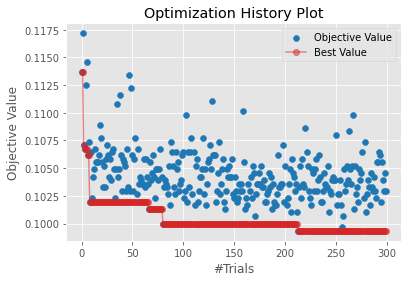

In [159]:
optuna.visualization.matplotlib.plot_optimization_history(study)

/var/folders/y5/l0mxxq7x5_qbppq852wnz_n00000gn/T/ipykernel_33975/437109074.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

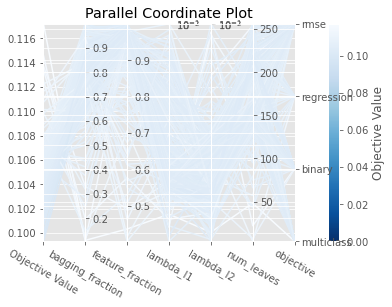

In [160]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study)

/var/folders/y5/l0mxxq7x5_qbppq852wnz_n00000gn/T/ipykernel_33975/2375574420.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


array([<AxesSubplot:xlabel='bagging_fraction', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='feature_fraction'>,
       <AxesSubplot:xlabel='lambda_l1'>, <AxesSubplot:xlabel='lambda_l2'>,
       <AxesSubplot:xlabel='num_leaves'>,
       <AxesSubplot:xlabel='objective'>], dtype=object)

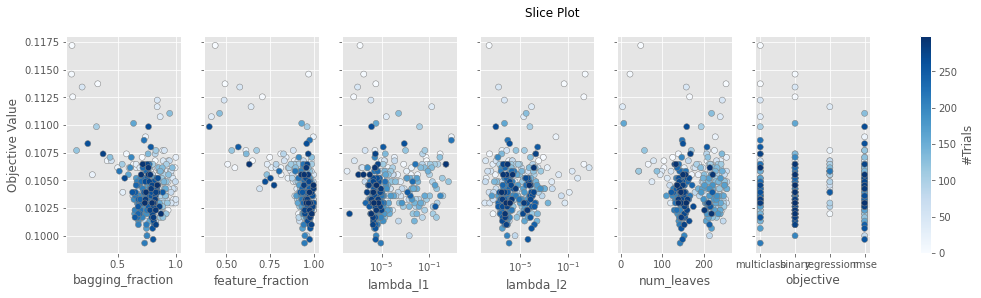

In [162]:
optuna.visualization.matplotlib.plot_slice(study)

/var/folders/y5/l0mxxq7x5_qbppq852wnz_n00000gn/T/ipykernel_33975/685618043.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','objective'])
[W 2022-07-20 14:24:40,757] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<AxesSubplot:title={'center':'Contour Plot'}, xlabel='num_leaves', ylabel='objective'>

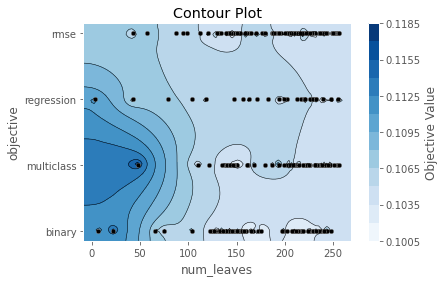

In [163]:
optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','objective'])

/var/folders/y5/l0mxxq7x5_qbppq852wnz_n00000gn/T/ipykernel_33975/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

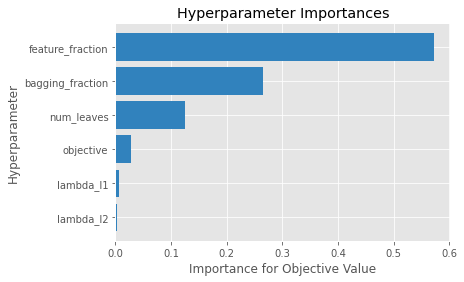

In [164]:
optuna.visualization.matplotlib.plot_param_importances(study)

/var/folders/y5/l0mxxq7x5_qbppq852wnz_n00000gn/T/ipykernel_33975/3191722373.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf(study)


<AxesSubplot:title={'center':'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

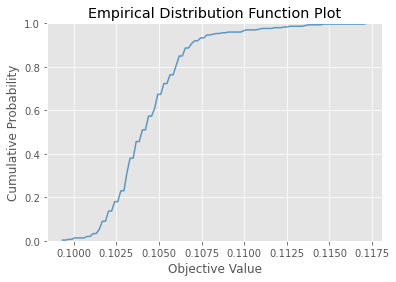

In [165]:
optuna.visualization.matplotlib.plot_edf(study)

In [166]:
Best_trial=study.best_trial.params
print(Best_trial)

{'num_leaves': 143, 'objective': 'multiclass', 'lambda_l1': 8.363108971238443e-06, 'lambda_l2': 1.1131157583236942e-06, 'bagging_fraction': 0.7308459380655236, 'feature_fraction': 0.9477590701424085}


In [168]:
preds = np.zeros((testX.shape[0],len(Name)))
kf = KFold(n_splits=5,random_state=48,shuffle=True)
for trn_idx, test_idx in kf.split(trainX[columns],trainY):
    X_tr,X_val=trainX[columns].iloc[trn_idx],trainX[columns].iloc[test_idx]
    y_tr,y_val=trainY.iloc[trn_idx],trainY.iloc[test_idx]
    model = lgb.LGBMClassifier(**Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    preds+=model.predict_proba(testX[columns])/kf.n_splits   ###### predict_proba
    rmse=mean_squared_error(y_val, model.predict(X_val),squared=False)
    print(rmse)

/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=8.363108971238443e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.363108971238443e-06
[LightGBM] [Warning] feature_fraction is set=0.9477590701424085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477590701424085
[LightGBM] [Warning] bagging_fraction is set=0.7308459380655236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7308459380655236
[LightGBM] [Warning] lambda_l2 is set=1.1131157583236942e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1131157583236942e-06
0.11135528725660043
[LightGBM] [Warning] lambda_l1 is set=8.363108971238443e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.363108971238443e-06
[LightGBM] [Warning] feature_fraction is set=0.9477590701424085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477590701424085
[LightGBM] [Warning] bagging_fraction is set=0.7308459380655236, subsample=1.0 will be ignored. Current v

/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.10583005244258362
[LightGBM] [Warning] lambda_l1 is set=8.363108971238443e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.363108971238443e-06
[LightGBM] [Warning] feature_fraction is set=0.9477590701424085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477590701424085
[LightGBM] [Warning] bagging_fraction is set=0.7308459380655236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7308459380655236
[LightGBM] [Warning] lambda_l2 is set=1.1131157583236942e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1131157583236942e-06


/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.10295630140987
[LightGBM] [Warning] lambda_l1 is set=8.363108971238443e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.363108971238443e-06
[LightGBM] [Warning] feature_fraction is set=0.9477590701424085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477590701424085
[LightGBM] [Warning] bagging_fraction is set=0.7308459380655236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7308459380655236
[LightGBM] [Warning] lambda_l2 is set=1.1131157583236942e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1131157583236942e-06


/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.1055146119422961
[LightGBM] [Warning] lambda_l1 is set=8.363108971238443e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.363108971238443e-06
[LightGBM] [Warning] feature_fraction is set=0.9477590701424085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9477590701424085
[LightGBM] [Warning] bagging_fraction is set=0.7308459380655236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7308459380655236
[LightGBM] [Warning] lambda_l2 is set=1.1131157583236942e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1131157583236942e-06


/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vicariousvision/miniforge3/envs/work/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.10614455552060438


In [169]:
display(preds)
preds2=np.argmax(preds,axis=1)
display(preds2)

array([[9.94189043e-01, 9.13179365e-04, 4.89777805e-03],
       [9.25782955e-04, 2.33261488e-04, 9.98840956e-01],
       [1.20853598e-03, 2.89177283e-04, 9.98502287e-01],
       ...,
       [9.96962454e-01, 1.77784082e-03, 1.25970489e-03],
       [9.98771074e-01, 2.96189309e-04, 9.32737002e-04],
       [3.24297018e-03, 3.31147756e-04, 9.96425882e-01]])

array([0, 2, 2, ..., 0, 0, 2])

In [170]:
print(classification_report(testY,preds2,target_names=Name))

              precision    recall  f1-score   support

      GALAXY       0.99      1.00      0.99     12767
         QSO       0.98      0.95      0.97      2659
        STAR       1.00      1.00      1.00      9574

    accuracy                           0.99     25000
   macro avg       0.99      0.98      0.99     25000
weighted avg       0.99      0.99      0.99     25000

